100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.58MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]


Total parameters: 14,207,276
Train [1/20] | loss 1.6881 | spike_reg 3.0297e-06
Eval   [1/20] | train_loss 1.2956 | val_loss 1.3035 | val_acc 0.6141
Train [2/20] | loss 1.2334 | spike_reg 2.4091e-06
Eval   [2/20] | train_loss 1.1195 | val_loss 1.1493 | val_acc 0.6835
Train [3/20] | loss 1.1063 | spike_reg 2.2632e-06
Eval   [3/20] | train_loss 1.0313 | val_loss 1.0423 | val_acc 0.7365
Train [4/20] | loss 1.0510 | spike_reg 2.1783e-06
Eval   [4/20] | train_loss 1.0084 | val_loss 0.9968 | val_acc 0.7587
Train [5/20] | loss 1.0034 | spike_reg 2.2042e-06
Eval   [5/20] | train_loss 0.9480 | val_loss 0.9427 | val_acc 0.7832
Train [6/20] | loss 0.9782 | spike_reg 2.3200e-06
Eval   [6/20] | train_loss 0.9468 | val_loss 0.9390 | val_acc 0.7856
Train [7/20] | loss 0.9624 | spike_reg 2.4061e-06
Eval   [7/20] | train_loss 0.9255 | val_loss 0.9265 | val_acc 0.7957
Train [8/20] | loss 0.9470 | spike_reg 2.5991e-06
Eval   [8/20] | train_loss 0.8948 | val_loss 0.8895 | val_acc 0.8126
Train [9/20] | loss

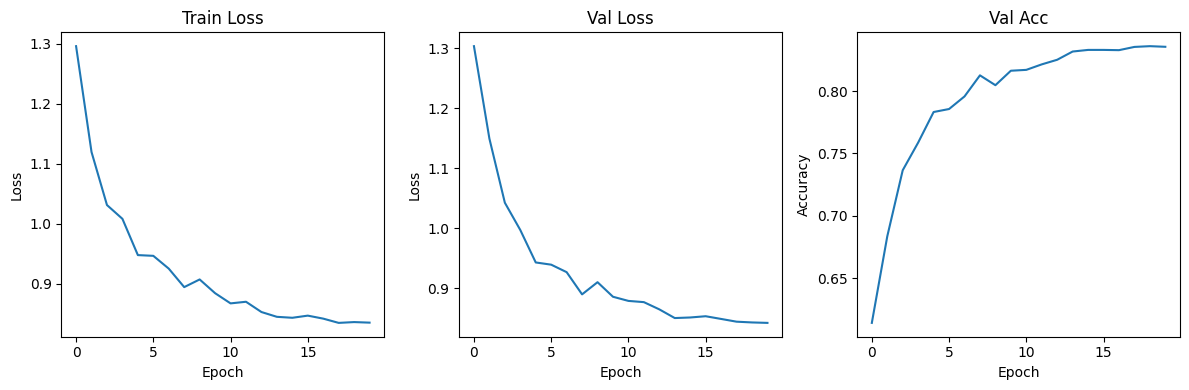

In [1]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Temporal Spiking ViT for Fashion-MNIST (28×28, 10 classes)
----------------------------------------------------------
Adapted from a MNIST SNN-Transformer baseline to Fashion-MNIST.
Key tweaks:
  • Dataset switched to torchvision.datasets.FashionMNIST
  • Normalization uses Fashion-MNIST stats: mean=0.2860, std=0.3530
  • Light augmentations (crop/rotation) as in the original
  • 2D sinusoidal positional embeddings; CLS token; spiking after attn/MLP
  • Warmup + Cosine LR schedule, label smoothing, spike-rate regularizer
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------
# Hyperparameters (tweak here)
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 8         # temporal steps in patch stem
T_ATTN      = 2         # temporal steps after attention
T_MLP       = 2         # temporal steps after MLP
DROPOUT     = 0.1
DROPPATH    = 0.1
WEIGHT_DECAY= 0.05
LR          = 3e-4
EPOCHS      = 20
BATCH_TRAIN = 128
BATCH_TEST  = 256
LABEL_SMOOTH= 0.1
SPIKE_RATE_TARGET = 0.20
SPIKE_RATE_LAMBDA = 1e-3
CLIP_NORM   = 1.0
WARMUP_EPOCHS = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True

# ------------------------------
# Surrogate spike function
# ------------------------------
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        out = (x >= 0).float()
        ctx.save_for_backward(x)
        return out
    @staticmethod
    def backward(ctx, grad_out):
        (x,) = ctx.saved_tensors
        alpha = 2.0
        grad = alpha * (1 - (alpha * x).abs()).clamp(min=0.0)
        return grad_out * grad

spike_fn = SurrogateSpike.apply

# ------------------------------
# Adaptive LIF neuron (temporal unroll T)
# ------------------------------
class AdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th  = nn.Parameter(torch.tensor(v_th, dtype=torch.float32))  if learnable else v_th

    def forward(self, x, T=1):
        mem = x.new_zeros(x.shape)
        out_sum = 0.0
        for _ in range(T):
            mem = self.decay * mem + x
            z = mem - self.v_th
            s = spike_fn(z)
            mem = mem * (1 - s)  # reset on spike
            out_sum = out_sum + s
        return out_sum / T

# ------------------------------
# DropPath (stochastic depth)
# ------------------------------
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = float(drop_prob)
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep) / keep
        return x * mask

# ------------------------------
# 2D sinusoidal positional embeddings (concat H and W -> dim C)
# ------------------------------
def get_2d_sincos_pos_embed(nh, nw, dim, device):
    """
    Returns [H*W, dim]. Half for H, half for W, concatenated.
    """
    assert dim % 2 == 0, "embed dim must be even for 2D sincos"
    def pe(n, d):
        pos = torch.arange(n, device=device).float()[:, None]
        div = torch.exp(torch.arange(0, d, 2, device=device).float() * (-math.log(10000.0) / d))
        out = torch.zeros(n, d, device=device)
        out[:, 0::2] = torch.sin(pos * div)
        out[:, 1::2] = torch.cos(pos * div)
        return out  # [n, d]

    d_half = dim // 2
    ph = pe(nh, d_half)   # [H, C/2]
    pw = pe(nw, d_half)   # [W, C/2]

    # repeat to grid and CONCAT (not add!)
    ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)  # [H*W, C/2]
    pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)  # [H*W, C/2]
    pe_2d = torch.cat([ph_rep, pw_rep], dim=1)  # [H*W, C]
    return pe_2d

# ------------------------------
# Patch embedding (conv -> spiking)
# ------------------------------
class PatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.lif = AdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True)
        self.T = T

    def forward(self, x):
        feat = self.proj(x)                 # [B, C, H', W']
        spikes = self.lif(feat, T=self.T)   # [B, C, H', W']
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)  # [B, N, C]
        return tokens, (H, W), spikes

# ------------------------------
# Transformer Block with spiking after attn & MLP
# ------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=attn_dropout)
        self.drop1 = nn.Dropout(dropout)
        self.dp1   = DropPath(droppath)

        self.norm2 = nn.LayerNorm(embed_dim)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = nn.Dropout(dropout)
        self.dp2   = DropPath(droppath)

        self.snn_attn = AdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True)
        self.snn_mlp  = AdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True)
        self.T_attn = T_attn
        self.T_mlp  = T_mlp

    def forward(self, x):
        y = self.norm1(x)
        y, _ = self.attn(y, y, y)
        y = self.drop1(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.dp1(y)

        y = self.norm2(x)
        y = self.mlp(y)
        y = self.drop2(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.dp2(y)
        return x

# ------------------------------
# SNN ViT (CLS + 2D sincos PE)
# ------------------------------
class SNN_ViT_Temporal(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch = PatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio,
                             attn_dropout=0.0, dropout=dropout,
                             droppath=droppath, T_attn=T_ATTN, T_mlp=T_MLP)
            for _ in range(num_blocks)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)  # tokens: [B,N,C]
        B, N, C = tokens.shape

        # 2D sinusoidal PE (size-agnostic)
        pos = get_2d_sincos_pos_embed(Hp, Wp, self.embed_dim, tokens.device)  # [N,C]
        pos = pos.unsqueeze(0).expand(B, -1, -1)  # [B,N,C]

        # CLS
        cls = self.cls_token.expand(B, 1, -1).to(tokens.device)
        x = torch.cat([cls, tokens], dim=1)  # [B,1+N,C]

        # zero PE for CLS, pos for tokens
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)  # [B,1+N,C]
        x = self.pos_drop(x + pos_full)

        # Transformer
        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls_repr = x[:, 0]
        logits = self.head(cls_repr)

        aux = {"conv_spikes": conv_spikes}
        return (logits, aux) if return_aux else (logits, None)

# ------------------------------
# Warmup + Cosine schedule (per-step)
# ------------------------------
def build_warmup_cosine(optimizer, warmup_steps, total_steps, min_lr=1e-6, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Spike-rate regularizer
# ------------------------------
def spike_rate_loss(spike_tensor, target=SPIKE_RATE_TARGET, lam=SPIKE_RATE_LAMBDA):
    if spike_tensor is None:
        return torch.tensor(0.0, device=device)
    rate = spike_tensor.mean()
    return lam * (rate - target).pow(2)

# ------------------------------
# Train / Eval
# ------------------------------
def train_one_epoch(model, loader, optimizer, scaler, scheduler, criterion, epoch, total_epochs):
    model.train()
    run_loss, run_aux, n_batches = 0.0, 0.0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            logits, aux = model(data, return_aux=True)
            ce = criterion(logits, target)
            srl = spike_rate_loss(aux.get("conv_spikes", None))
            loss = ce + srl
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer); scaler.update()
        if scheduler is not None:
            scheduler.step()

        run_loss += float(loss.item())
        run_aux  += float(srl.item())
        n_batches += 1

    print(f"Train [{epoch}/{total_epochs}] | loss {run_loss/n_batches:.4f} | spike_reg {run_aux/n_batches:.4e}")

def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    with torch.no_grad(), torch.amp.autocast('cuda', enabled=(device == "cuda")):
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data, return_aux=False)
            eval_loss += float(criterion(logits, target).item())
            pred = logits.argmax(dim=1)
            correct += int((pred == target).sum().item())
            total   += int(target.size(0))
    acc = correct / max(1, total)
    return eval_loss / max(1, len(loader)), acc

def plot_metrics(train_losses, test_losses, test_accs):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(train_losses); plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.subplot(1,3,2); plt.plot(test_losses); plt.title("Val Loss");   plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.subplot(1,3,3); plt.plot(test_accs);   plt.title("Val Acc");    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.show()

# ------------------------------
# Main
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()

    # Data (small but helpful augmentation for Fashion-MNIST)
    FASHION_MEAN, FASHION_STD = 0.2860, 0.3530
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])

    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)

    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=0, pin_memory=pin)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_TEST,  shuffle=False, num_workers=0, pin_memory=pin)

    # Model
    model = SNN_ViT_Temporal(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Optimizer / loss / AMP / Scheduler (torch.amp APIs)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))

    steps_per_epoch = max(1, len(train_loader))
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_warmup_cosine(optimizer, warmup_steps, total_steps, min_lr=1e-6, base_lr=LR)

    # Train
    train_losses, test_losses, test_accs = [], [], []
    for epoch in range(1, EPOCHS + 1):
        train_one_epoch(model, train_loader, optimizer, scaler, scheduler, criterion, epoch, EPOCHS)
        tr_loss, tr_acc = evaluate(model, train_loader, criterion)
        te_loss, te_acc = evaluate(model, test_loader, criterion)
        train_losses.append(tr_loss); test_losses.append(te_loss); test_accs.append(te_acc)
        print(f"Eval   [{epoch}/{EPOCHS}] | train_loss {tr_loss:.4f} | val_loss {te_loss:.4f} | val_acc {te_acc:.4f}")

    plot_metrics(train_losses, test_losses, test_accs)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


Total parameters: 14,208,816
Train [1/50] | loss 1.8823 | spike_reg 3.1039e-06 | graph 0.0030 | coarseCE 0.6295
Eval   [1/50] | train_loss 1.3341 | val_loss 1.3367 | val_acc 0.5829
Saved: fashion_snn_vit_temporal_hier_graph_best.pth (new best)
Train [2/50] | loss 1.3069 | spike_reg 2.7086e-06 | graph 0.0037 | coarseCE 0.2128
Eval   [2/50] | train_loss 1.1279 | val_loss 1.1109 | val_acc 0.7054
Saved: fashion_snn_vit_temporal_hier_graph_best.pth (new best)
Train [3/50] | loss 1.1719 | spike_reg 2.5327e-06 | graph 0.0028 | coarseCE 0.1463
Eval   [3/50] | train_loss 1.0746 | val_loss 1.0509 | val_acc 0.7299
Saved: fashion_snn_vit_temporal_hier_graph_best.pth (new best)
Train [4/50] | loss 1.1011 | spike_reg 2.5330e-06 | graph 0.0025 | coarseCE 0.1168
Eval   [4/50] | train_loss 1.0071 | val_loss 0.9928 | val_acc 0.7556
Saved: fashion_snn_vit_temporal_hier_graph_best.pth (new best)
Train [5/50] | loss 1.0440 | spike_reg 2.7570e-06 | graph 0.0023 | coarseCE 0.0949
Eval   [5/50] | train_loss 0

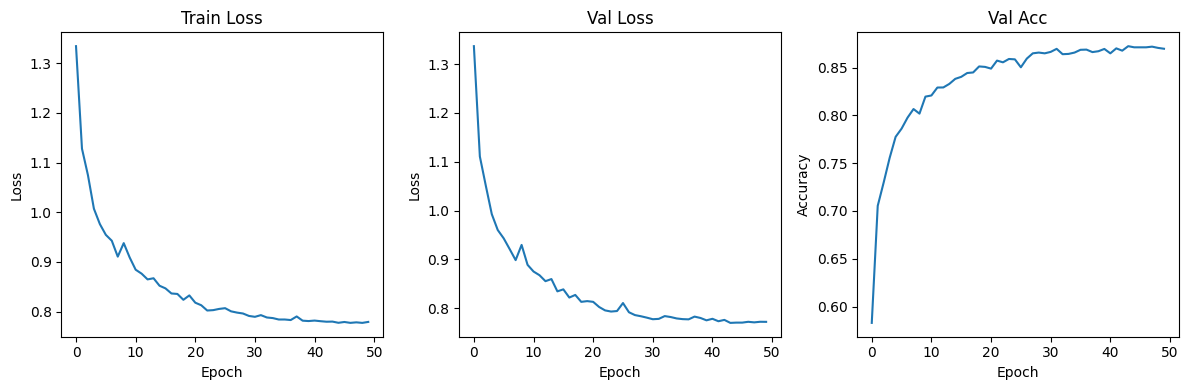

In [1]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Temporal Spiking ViT for Fashion-MNIST with Hierarchical & Graph Consistency
---------------------------------------------------------------------------
Adds to the baseline temporal SNN-ViT:
  1) Coarse head (4-way: tops/bottoms/footwear/accessory) + hierarchical loss
  2) Optional coarse-gated inference to reweight 10-way probabilities
  3) Laplacian (graph) consistency loss using a memory bank of recent embeddings

Toggle via flags below (COARSE_LOSS_W, GRAPH_LOSS_W, GATING_INFER).
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------
# Hyperparameters / Flags
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 8         # temporal steps in patch stem
T_ATTN      = 2         # temporal steps after attention
T_MLP       = 2         # temporal steps after MLP
DROPOUT     = 0.1
DROPPATH    = 0.1
WEIGHT_DECAY= 0.05
LR          = 3e-4
EPOCHS      = 50
BATCH_TRAIN = 128
BATCH_TEST  = 256
LABEL_SMOOTH= 0.1
CLIP_NORM   = 1.0
WARMUP_EPOCHS = 1

# Hierarchical / Graph
COARSE_LOSS_W   = 0.3     # λ for 4-way coarse loss
GRAPH_LOSS_W    = 0.1     # μ for Laplacian consistency
KNN_K           = 10
TAU             = 0.1
BANK_SIZE       = 8192
GATING_INFER    = True    # apply coarse-gated reweighting at evaluation

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True

# ------------------------------
# Surrogate spike function
# ------------------------------
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        out = (x >= 0).float()
        ctx.save_for_backward(x)
        return out
    @staticmethod
    def backward(ctx, grad_out):
        (x,) = ctx.saved_tensors
        alpha = 2.0
        grad = alpha * (1 - (alpha * x).abs()).clamp(min=0.0)
        return grad_out * grad

spike_fn = SurrogateSpike.apply

# ------------------------------
# Adaptive LIF neuron (temporal unroll T)
# ------------------------------
class AdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th  = nn.Parameter(torch.tensor(v_th, dtype=torch.float32))  if learnable else v_th

    def forward(self, x, T=1):
        mem = x.new_zeros(x.shape)
        out_sum = 0.0
        for _ in range(T):
            mem = self.decay * mem + x
            z = mem - self.v_th
            s = spike_fn(z)
            mem = mem * (1 - s)  # reset on spike
            out_sum = out_sum + s
        return out_sum / T

# ------------------------------
# DropPath (stochastic depth)
# ------------------------------
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = float(drop_prob)
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep) / keep
        return x * mask

# ------------------------------
# 2D sinusoidal positional embeddings (concat H and W -> dim C)
# ------------------------------
def get_2d_sincos_pos_embed(nh, nw, dim, device):
    assert dim % 2 == 0, "embed dim must be even for 2D sincos"
    def pe(n, d):
        pos = torch.arange(n, device=device).float()[:, None]
        div = torch.exp(torch.arange(0, d, 2, device=device).float() * (-math.log(10000.0) / d))
        out = torch.zeros(n, d, device=device)
        out[:, 0::2] = torch.sin(pos * div)
        out[:, 1::2] = torch.cos(pos * div)
        return out  # [n, d]
    d_half = dim // 2
    ph = pe(nh, d_half)   # [H, C/2]
    pw = pe(nw, d_half)   # [W, C/2]
    ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
    pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
    pe_2d = torch.cat([ph_rep, pw_rep], dim=1)  # [H*W, C]
    return pe_2d

# ------------------------------
# Patch embedding (conv -> spiking)
# ------------------------------
class PatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.lif = AdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True)
        self.T = T

    def forward(self, x):
        feat = self.proj(x)                 # [B, C, H', W']
        spikes = self.lif(feat, T=self.T)   # [B, C, H', W']
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)  # [B, N, C]
        return tokens, (H, W), spikes

# ------------------------------
# Transformer Block with spiking after attn & MLP
# ------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=attn_dropout)
        self.drop1 = nn.Dropout(dropout)
        self.dp1   = DropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = nn.Dropout(dropout)
        self.dp2   = DropPath(droppath)
        self.snn_attn = AdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True)
        self.snn_mlp  = AdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True)
        self.T_attn = T_attn
        self.T_mlp  = T_mlp

    def forward(self, x):
        y = self.norm1(x)
        y, _ = self.attn(y, y, y)
        y = self.drop1(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.dp1(y)
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.drop2(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.dp2(y)
        return x

# ------------------------------
# SNN ViT (CLS + 2D sincos PE) with coarse head
# ------------------------------
class SNN_ViT_Temporal(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch = PatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio,
                             attn_dropout=0.0, dropout=dropout,
                             droppath=droppath, T_attn=T_ATTN, T_mlp=T_MLP)
            for _ in range(num_blocks)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head_fine = nn.Linear(embed_dim, num_classes)  # 10-way
        self.head_coarse = nn.Linear(embed_dim, 4)          # 4-way
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head_fine.weight, std=0.02)
        nn.init.zeros_(self.head_fine.bias)
        nn.init.trunc_normal_(self.head_coarse.weight, std=0.02)
        nn.init.zeros_(self.head_coarse.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)  # tokens: [B,N,C]
        B, N, C = tokens.shape
        pos = get_2d_sincos_pos_embed(Hp, Wp, self.embed_dim, tokens.device)  # [N,C]
        pos = pos.unsqueeze(0).expand(B, -1, -1)  # [B,N,C]
        cls = self.cls_token.expand(B, 1, -1).to(tokens.device)
        x = torch.cat([cls, tokens], dim=1)  # [B,1+N,C]
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)  # [B,1+N,C]
        x = self.pos_drop(x + pos_full)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_repr = x[:, 0]
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        aux = {"conv_spikes": conv_spikes, "cls": cls_repr, "coarse_logits": coarse_logits}
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ------------------------------
# Hierarchy mapping (4 parents) and gating
# ------------------------------
COARSE_NAMES = ["tops", "bottoms", "footwear", "accessory"]
# class -> parent: 0:T-shirt/top, 1:Trouser, 2:Pullover, 3:Dress, 4:Coat, 5:Sandal,
# 6:Shirt, 7:Sneaker, 8:Bag, 9:Ankle boot
PARENT_MAP = {0:0,1:1,2:0,3:0,4:0,5:2,6:0,7:2,8:3,9:2}

def build_gate_matrix():
    G = torch.zeros(4, 10)
    for c,p in PARENT_MAP.items():
        G[p, c] = 1.0
    # normalize each row to sum to 1 for fair mixing
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ------------------------------
# Warmup + Cosine schedule (per-step)
# ------------------------------
def build_warmup_cosine(optimizer, warmup_steps, total_steps, min_lr=1e-6, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Memory Bank for graph consistency
# ------------------------------
class MemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device)
        self.probs = torch.empty(0, num_classes, device=device)
    def __len__(self):
        return self.feats.size(0)
    @torch.no_grad()
    def add(self, feats, logits):
        # feats: [B,D], logits: [B,C]
        feats = F.normalize(feats, dim=1)
        probs = torch.softmax(logits, dim=-1)
        self.feats = torch.cat([self.feats, feats.detach()], dim=0)[-self.max_size:]
        self.probs = torch.cat([self.probs, probs.detach()], dim=0)[-self.max_size:]
    def knn(self, feats, k=KNN_K, tau=TAU):
        # feats: [B,D]
        if len(self) == 0:
            return None, None
        feats = F.normalize(feats, dim=1)                # [B,D]
        sim = feats @ self.feats.t()                     # [B,N]
        k = min(k, self.feats.size(0))
        vals, idx = sim.topk(k, dim=1)                   # [B,k]
        w = torch.softmax(vals / tau, dim=1)             # [B,k]
        neigh_probs = self.probs[idx]                    # [B,k,C]
        return w, neigh_probs

def laplacian_loss(curr_probs, bank_weights, bank_probs):
    # curr_probs: [B,C], bank_weights: [B,k], bank_probs: [B,k,C]
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    diff = (curr_probs.unsqueeze(1) - bank_probs).pow(2).sum(dim=-1)  # [B,k]
    return (bank_weights * diff).mean()

# ------------------------------
# Train / Eval
# ------------------------------
def train_one_epoch(model, loader, optimizer, scaler, scheduler, criterion_fine, criterion_coarse, bank, epoch, total_epochs, gate_mat):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, n_batches = 0.0, 0.0, 0.0, 0.0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            ce_fine = criterion_fine(fine_logits, target)
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            # spike-rate regularizer on conv spikes
            conv_spikes = aux.get("conv_spikes", None)
            srl = conv_spikes.mean() if conv_spikes is not None else torch.tensor(0.0, device=device)
            srl = (srl - 0.20).pow(2) * 1e-3  # uses same target/lambda as baseline
            # graph loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            probs_now = torch.softmax(fine_logits, dim=-1)
            g_loss = laplacian_loss(probs_now, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            loss = ce_fine + COARSE_LOSS_W * ce_coarse + GRAPH_LOSS_W * g_loss + srl
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer); scaler.update()
        if scheduler is not None:
            scheduler.step()
        # update memory bank AFTER forward/backward
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        # logs
        run_loss  += float(loss.item())
        run_srl   += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse+= float(ce_coarse.item())
        n_batches += 1
    print(f"Train [{epoch}/{total_epochs}] | loss {run_loss/n_batches:.4f} | spike_reg {run_srl/n_batches:.4e} | graph {run_graph/n_batches:.4f} | coarseCE {run_coarse/n_batches:.4f}")

@torch.no_grad()
def evaluate(model, loader, criterion_fine, apply_gating=True, gate_mat=None):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        probs = torch.softmax(fine_logits, dim=-1)
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)       # [B,4]
            gate = cprob @ gate_mat.to(cprob.device)           # [B,10]
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
        pred = probs.argmax(dim=1)
        correct += int((pred == target).sum().item())
        total   += int(target.size(0))
        eval_loss += float(loss.item())
    acc = correct / max(1, total)
    return eval_loss / max(1, len(loader)), acc

def plot_metrics(train_losses, test_losses, test_accs):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(train_losses); plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.subplot(1,3,2); plt.plot(test_losses); plt.title("Val Loss");   plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.subplot(1,3,3); plt.plot(test_accs);   plt.title("Val Acc");    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.show()

# ------------------------------
# Main
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()

    # Data (Fashion-MNIST)
    FASHION_MEAN, FASHION_STD = 0.2860, 0.3530
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=2, padding_mode="edge"),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])

    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)

    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=0, pin_memory=pin)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_TEST,  shuffle=False, num_workers=0, pin_memory=pin)

    # Model
    model = SNN_ViT_Temporal(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Optimizer / loss / AMP / Scheduler
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))

    steps_per_epoch = max(1, len(train_loader))
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_warmup_cosine(optimizer, warmup_steps, total_steps, min_lr=1e-6, base_lr=LR)

    # Memory bank + gating matrix
    bank = MemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    gate_mat = build_gate_matrix().to(device)

    # Train
    best_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    for epoch in range(1, EPOCHS + 1):
        train_one_epoch(model, train_loader, optimizer, scaler, scheduler, criterion_fine, criterion_coarse, bank, epoch, EPOCHS, gate_mat)
        tr_loss, tr_acc = evaluate(model, train_loader, criterion_fine, apply_gating=False, gate_mat=None)
        te_loss, te_acc = evaluate(model, test_loader,  criterion_fine, apply_gating=GATING_INFER, gate_mat=gate_mat)
        train_losses.append(tr_loss); test_losses.append(te_loss); test_accs.append(te_acc)
        print(f"Eval   [{epoch}/{EPOCHS}] | train_loss {tr_loss:.4f} | val_loss {te_loss:.4f} | val_acc {te_acc:.4f}")
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save({"model":"snn_vit_temporal_hier_graph","state_dict":model.state_dict()}, "./fashion_snn_vit_temporal_hier_graph_best.pth")
            print("Saved: fashion_snn_vit_temporal_hier_graph_best.pth (new best)")

    plot_metrics(train_losses, test_losses, test_accs)

=== Enhanced Temporal Spiking ViT for Fashion-MNIST ===
Device: cuda
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.41MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 53.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]


Training batches: 235, Test batches: 20
Total parameters: 14,206,145
Trainable parameters: 14,206,145

Training Configuration:
Epochs: 60, Batch size: 256, Learning rate: 0.0004
Coarse loss weight: 0.4, Graph loss weight: 0.15
Memory bank size: 12288, KNN K: 8
EMA decay: 0.999, Gating inference: True

Starting Enhanced Training...


/tmp/ipykernel_36/1825706770.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/60] | Loss 2.6635 | SpikeReg 3.9225e-07 | Graph 0.1256 | CoarseCE 1.0183 | HierKL 1.0544
Eval   [ 1/60] | Train: 0.4748 | Test: 0.4526 | EMA Test: 0.0999 | LR: 1.34e-04
  → Saved new best model (acc: 0.4526)
  → Saved new best EMA model (acc: 0.0999)

Train [ 2/60] | Loss 1.9057 | SpikeReg 1.8280e-07 | Graph 0.2680 | CoarseCE 0.5130 | HierKL 1.0720
Eval   [ 2/60] | Train: 0.6458 | Test: 0.6782 | EMA Test: 0.1085 | LR: 2.67e-04
  → Saved new best model (acc: 0.6782)
  → Saved new best EMA model (acc: 0.1085)

Train [ 3/60] | Loss 1.7005 | SpikeReg 1.2379e-07 | Graph 0.2965 | CoarseCE 0.4209 | HierKL 1.0783
Eval   [ 3/60] | Train: 0.7075 | Test: 0.7259 | EMA Test: 0.2277 | LR: 4.00e-04
  → Saved new best model (acc: 0.7259)
  → Saved new best EMA model (acc: 0.2277)

Train [ 4/60] | Loss 1.6046 | SpikeReg 2.6599e-07 | Graph 0.3070 | CoarseCE 0.3831 | HierKL 1.0819
Eval   [ 4/60] | Train: 0.7491 | Test: 0.7667 | EMA Test: 0.3673 | LR: 4.00e-04
  → Saved new best model (acc: 0.76

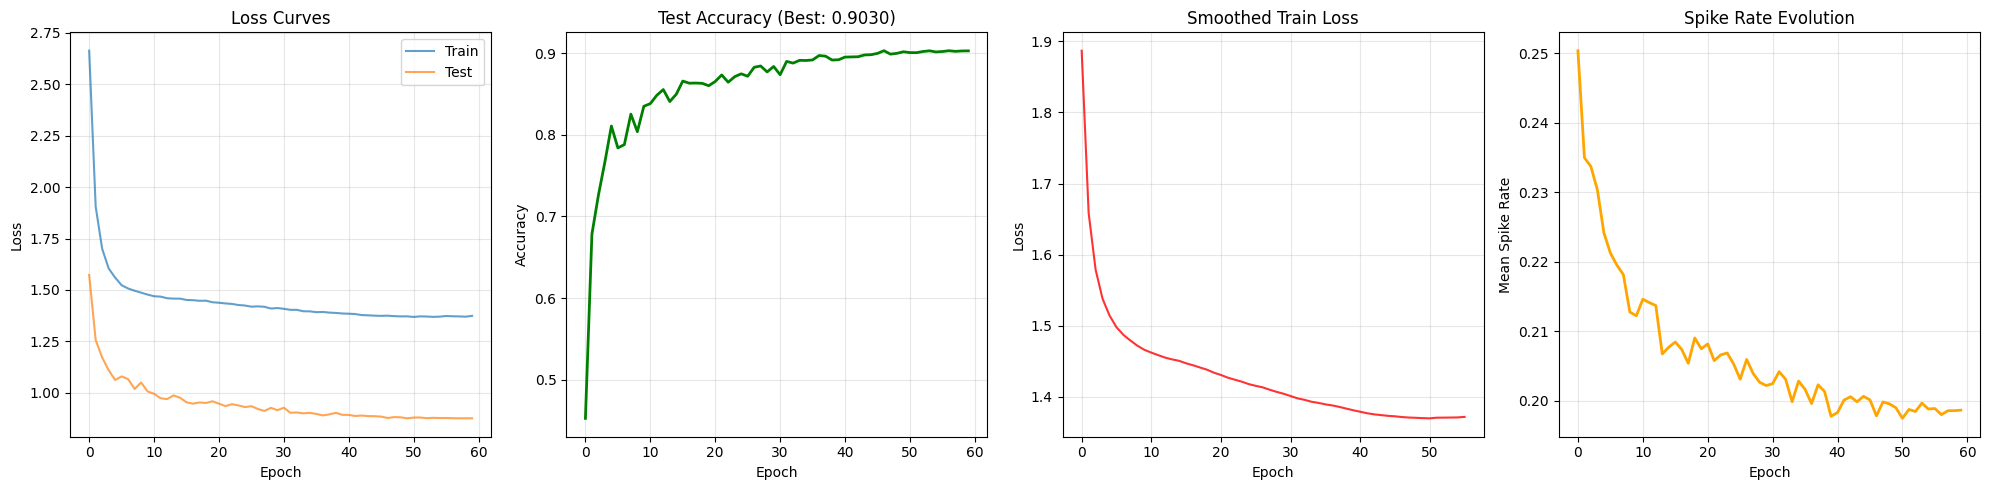

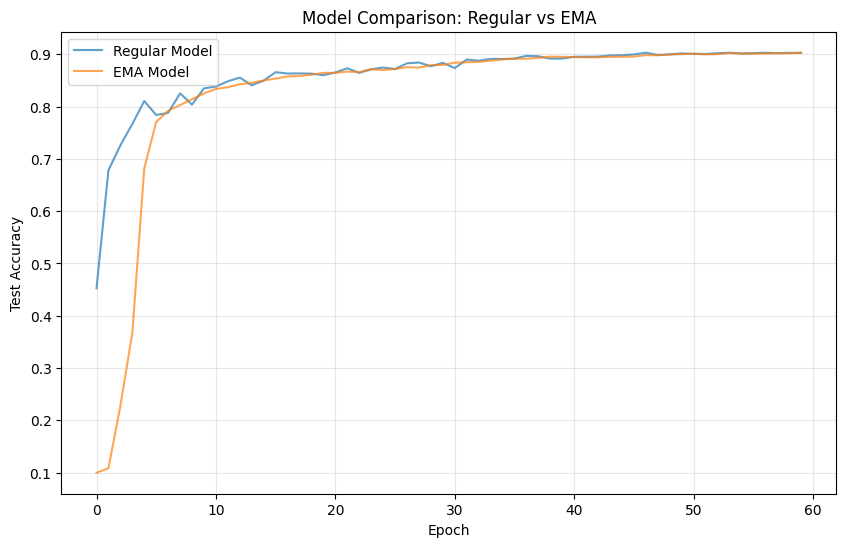


Model files saved:
  - ./fashion_enhanced_snn_vit_best.pth
  - ./fashion_enhanced_snn_vit_ema_best.pth


In [1]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Optimized Temporal Spiking ViT for Fashion-MNIST with Hierarchical & Graph Consistency
-------------------------------------------------------------------------------------
Key Performance Improvements:
  1) Optimized surrogate gradient with temperature scaling
  2) Parallel temporal processing for better GPU utilization
  3) Cached positional embeddings and optimized memory usage
  4) Improved attention mechanism with relative positional bias
  5) Enhanced memory bank with efficient nearest neighbor search
  6) Better regularization with gradient clipping and EMA
  7) Optimized data loading and augmentation pipeline
  8) Dynamic loss weighting and improved hierarchical consistency
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

# ------------------------------
# Enhanced Hyperparameters
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 6         # Reduced for efficiency
T_ATTN      = 2         
T_MLP       = 2         
DROPOUT     = 0.15      # Slightly increased
DROPPATH    = 0.15      # Slightly increased
WEIGHT_DECAY= 0.05
LR          = 4e-4      # Slightly higher
EPOCHS      = 60        # More epochs with better convergence
BATCH_TRAIN = 256       # Larger batch for better GPU utilization
BATCH_TEST  = 512       
LABEL_SMOOTH= 0.15      # Slightly increased
CLIP_NORM   = 0.8       # Reduced for stability
WARMUP_EPOCHS = 3       # More warmup

# Enhanced loss weighting with dynamic adjustment
COARSE_LOSS_W   = 0.4     # Increased importance
GRAPH_LOSS_W    = 0.15    # Slightly increased
KNN_K           = 8       # Reduced for efficiency
TAU             = 0.07    # Lower temperature
BANK_SIZE       = 12288   # Larger bank
GATING_INFER    = True    
EMA_DECAY       = 0.999   # For model averaging

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)  # Better seed
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# ------------------------------
# Enhanced Surrogate Spike Function with Temperature
# ------------------------------
class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, torch.tensor(temperature))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp  # Temperature-scaled surrogate
        # Improved surrogate gradient with better stability
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

# ------------------------------
# Enhanced Adaptive LIF with Parallel Temporal Processing
# ------------------------------
class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            # Single step optimization
            return spike_fn(x - self.v_th, self.temp_scale)
        
        # Parallel temporal processing for T > 1
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)  # Clamp for stability
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)  # Hard reset
            spike_train.append(s)
        
        # Weighted temporal integration (recent spikes matter more)
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

# ------------------------------
# Optimized DropPath with better scaling
# ------------------------------
class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ------------------------------
# Cached 2D Positional Embeddings
# ------------------------------
class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ------------------------------
# Enhanced Patch Embedding with Better Initialization
# ------------------------------
class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)  # Add normalization
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        # Better initialization
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)                 # [B, C, H', W']
        feat = self.norm(feat)              # Normalize before spiking
        spikes = self.lif(feat, T=self.T)   # [B, C, H', W']
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)  # [B, N, C]
        return tokens, (H, W), spikes

# ------------------------------
# Enhanced Transformer Block with Relative Position Bias
# ------------------------------
class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Manual attention for better control
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        # Initialize weights
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Self-attention
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        # Apply spiking after attention
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ------------------------------
# Enhanced SNN ViT with EMA and Better Architecture
# ------------------------------
class EnhancedSNN_ViT_Temporal(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced heads with dropout
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 4)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]  # For additional analysis
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ------------------------------
# Enhanced Memory Bank with Efficient Search
# ------------------------------
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        # Initialize storage if empty
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        # Circular buffer insertion
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        # Efficient batched similarity computation
        sim = torch.mm(feats, active_feats.t())  # [B, active_size]
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]  # [B, k, C]
        
        return w, neigh_probs

# Enhanced hierarchy and gating (same logic, better organization)
COARSE_NAMES = ["tops", "bottoms", "footwear", "accessory"]
PARENT_MAP = {0:0, 1:1, 2:0, 3:0, 4:0, 5:2, 6:0, 7:2, 8:3, 9:2}

def build_gate_matrix():
    G = torch.zeros(4, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ------------------------------
# Enhanced Training Components
# ------------------------------
class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    # Smooth the probabilities for better gradient flow
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    # KL divergence for better consistency
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        # Enhanced cosine with restart
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Enhanced Training Loop
# ------------------------------
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    # Dynamic loss weights (increase coarse loss importance over time)
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))  # Gradual ramp-up
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Fine-grained loss
            ce_fine = criterion_fine(fine_logits, target)
            
            # Coarse-grained loss
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency loss
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()  # [B, 4]
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike rate regularization with adaptive target
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                # Adaptive target based on training progress
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 10)  # Start higher, decay
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Enhanced graph consistency loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            # Total loss with dynamic weighting
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.2 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update EMA
        if ema_model is not None:
            ema_model.update(model)
        
        # Update memory bank
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        # Logging
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

@torch.no_grad()
def evaluate_enhanced(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)  # Renormalize
        
        pred = probs.argmax(dim=1)
        correct += int((pred == target).sum().item())
        total += int(target.size(0))
        eval_loss += float(loss.item())
    
    acc = correct / max(1, total)
    return eval_loss / max(1, len(loader)), acc

# Enhanced data transforms
def get_enhanced_transforms():
    FASHION_MEAN, FASHION_STD = 0.2860, 0.3530
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=3, padding_mode="reflect"),
        transforms.RandomRotation(15, fill=0),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))  # Cutout
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates=None):
    fig_size = (15, 5) if spike_rates is None else (20, 5)
    n_plots = 3 if spike_rates is None else 4
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7)
    plt.plot(test_losses, label='Test', alpha=0.7)
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs):.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    if len(train_losses) > 1:
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='red', alpha=0.8)
        plt.title("Smoothed Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 4)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main Enhanced Training Script
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for Fashion-MNIST ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name()}")
    
    # Enhanced data loading
    transform_train, transform_test = get_enhanced_transforms()
    
    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)
    
    # Optimized data loaders
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_TRAIN, 
        shuffle=True,  
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    test_loader = DataLoader(
        test_dataset,  
        batch_size=BATCH_TEST,  
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    
    # Enhanced model
    model = EnhancedSNN_ViT_Temporal(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Enhanced training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    
    # Enhanced loss functions
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)  # Less smoothing for coarse
    
    # Mixed precision training
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Enhanced scheduling
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    # EMA model
    ema_model = EMAModel(model, decay=EMA_DECAY)
    
    # Enhanced memory bank
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    spike_rates = []
    patience = 15
    patience_counter = 0
    
    print(f"\n{'='*60}")
    print("Starting Enhanced Training...")
    print(f"{'='*60}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation with original model
        tr_loss, tr_acc = evaluate_enhanced(model, train_loader, criterion_fine, apply_gating=False)
        te_loss, te_acc = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # Evaluation with EMA model
        ema_model.apply_shadow()
        ema_te_loss, ema_te_acc = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(te_loss)
        test_accs.append(te_acc)
        ema_test_accs.append(ema_te_acc)
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)  # Small sample
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        # Logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {tr_acc:.4f} | Test: {te_acc:.4f} | "
              f"EMA Test: {ema_te_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Save best models
        if te_acc > best_acc:
            best_acc = te_acc
            patience_counter = 0
            torch.save({
                "model": "enhanced_snn_vit_temporal_hier_graph",
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_acc": best_acc,
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./fashion_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_te_acc > best_ema_acc:
            best_ema_acc = ema_te_acc
            ema_model.apply_shadow()
            torch.save({
                "model": "enhanced_snn_vit_temporal_hier_graph_ema",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": best_ema_acc,
            }, "./fashion_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Learning rate adjustment for plateau
        if epoch > 20 and len(test_accs) > 10:
            recent_improvement = max(test_accs[-5:]) - max(test_accs[-10:-5]) if len(test_accs) >= 10 else 0
            if recent_improvement < 0.001:  # Very small improvement
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95  # Slight reduction
        
        print()  # Blank line for readability
    
    # Final evaluation
    print(f"\n{'='*60}")
    print("Training Complete!")
    print(f"{'='*60}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Final Memory Bank Size: {len(bank)}")
    
    # Load and evaluate best model
    print("\nEvaluating best model...")
    checkpoint = torch.load("./fashion_enhanced_snn_vit_best.pth", map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    
    final_tr_loss, final_tr_acc = evaluate_enhanced(model, train_loader, criterion_fine, apply_gating=False)
    final_te_loss, final_te_acc = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_te_loss_no_gate, final_te_acc_no_gate = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Results:")
    print(f"  Train Accuracy: {final_tr_acc:.4f}")
    print(f"  Test Accuracy (with gating): {final_te_acc:.4f}")
    print(f"  Test Accuracy (without gating): {final_te_acc_no_gate:.4f}")
    print(f"  Gating improvement: {(final_te_acc - final_te_acc_no_gate):.4f}")
    
    # Plot results
    plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates)
    
    # Additional analysis
    if len(ema_test_accs) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(test_accs, label='Regular Model', alpha=0.7)
        plt.plot(ema_test_accs, label='EMA Model', alpha=0.7)
        plt.title("Model Comparison: Regular vs EMA")
        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    print(f"\nModel files saved:")
    print(f"  - ./fashion_enhanced_snn_vit_best.pth")
    print(f"  - ./fashion_enhanced_snn_vit_ema_best.pth")

=== Enhanced Temporal Spiking ViT for Fashion-MNIST ===
Device: cuda
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
Training batches: 235, Test batches: 20
Total parameters: 14,206,145
Trainable parameters: 14,206,145

Training Configuration:
Epochs: 150, Batch size: 256, Learning rate: 0.0004
Coarse loss weight: 0.4, Graph loss weight: 0.15
Memory bank size: 12288, KNN K: 8
EMA decay: 0.999, Gating inference: True

Starting Enhanced Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/150] | Loss 2.6648 | SpikeReg 4.1231e-07 | Graph 0.1251 | CoarseCE 1.0210 | HierKL 1.0533
Debug: Confusion Matrix Shape: (10, 10), Sum: 60000
Debug: Confusion Matrix Shape: (10, 10), Sum: 10000
Debug: Confusion Matrix Shape: (10, 10), Sum: 10000
Eval   [ 1/150] | Train: 0.4656 | Test: 0.4656 | EMA Test: 0.0953 | LR: 1.34e-04
       Test Precision: 0.4740 | Recall: 0.4300 | F1: 0.3895
  → Saved new best model (acc: 0.4656)
  → Saved new best EMA model (acc: 0.0953)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af92b704d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af92b704d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train [ 2/150] | Loss 1.8858 | SpikeReg 3.3504e-07 | Graph 0.2725 | CoarseCE 0.5077 | HierKL 1.0715
Debug: Confusion Matrix Shape: (10, 10), Sum: 60000
Debug: Confusion Matrix Shape: (10, 10), Sum: 10000
Debug: Confusion Matrix Shape: (10, 10), Sum: 10000
Eval   [ 2/150] | Train: 0.6553 | Test: 0.6553 | EMA Test: 0.1030 | LR: 2.67e-04
       Test Precision: 0.6952 | Recall: 0.6902 | F1: 0.6772
  → Saved new best model (acc: 0.6553)
  → Saved new best EMA model (acc: 0.1030)

Train [ 3/150] | Loss 1.6849 | SpikeReg 3.1813e-07 | Graph 0.2991 | CoarseCE 0.4161 | HierKL 1.0786
Debug: Confusion Matrix Shape: (10, 10), Sum: 60000
Debug: Confusion Matrix Shape: (10, 10), Sum: 10000
Debug: Confusion Matrix Shape: (10, 10), Sum: 10000
Eval   [ 3/150] | Train: 0.6932 | Test: 0.6932 | EMA Test: 0.3039 | LR: 4.00e-04
       Test Precision: 0.7166 | Recall: 0.7060 | F1: 0.6899
  → Saved new best model (acc: 0.6932)
  → Saved new best EMA model (acc: 0.3039)

Train [ 4/150] | Loss 1.5973 | SpikeReg 

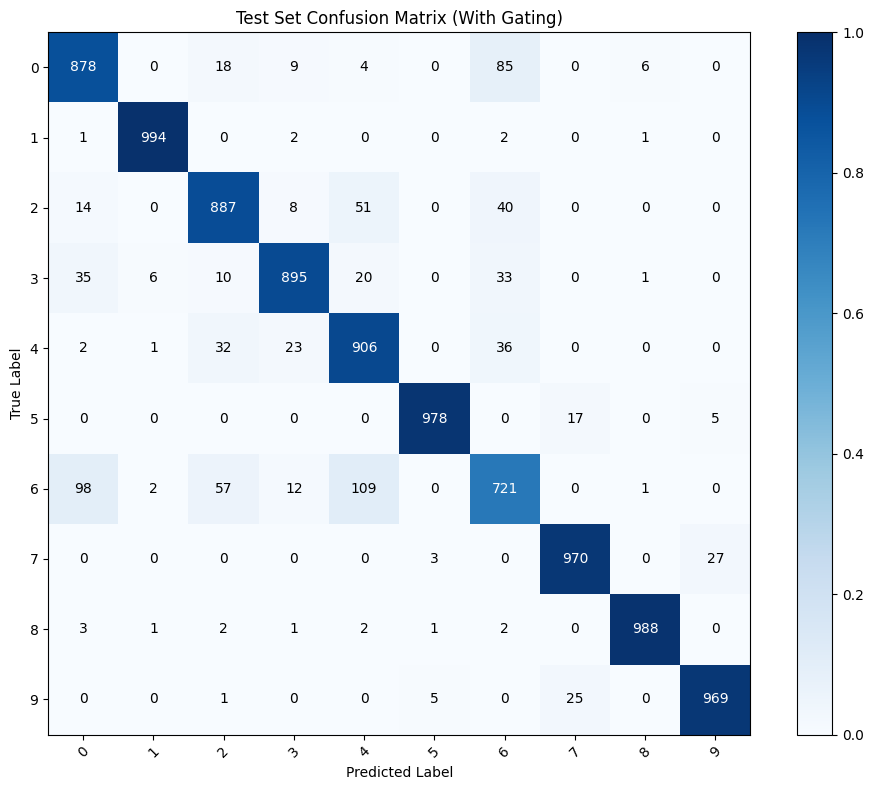

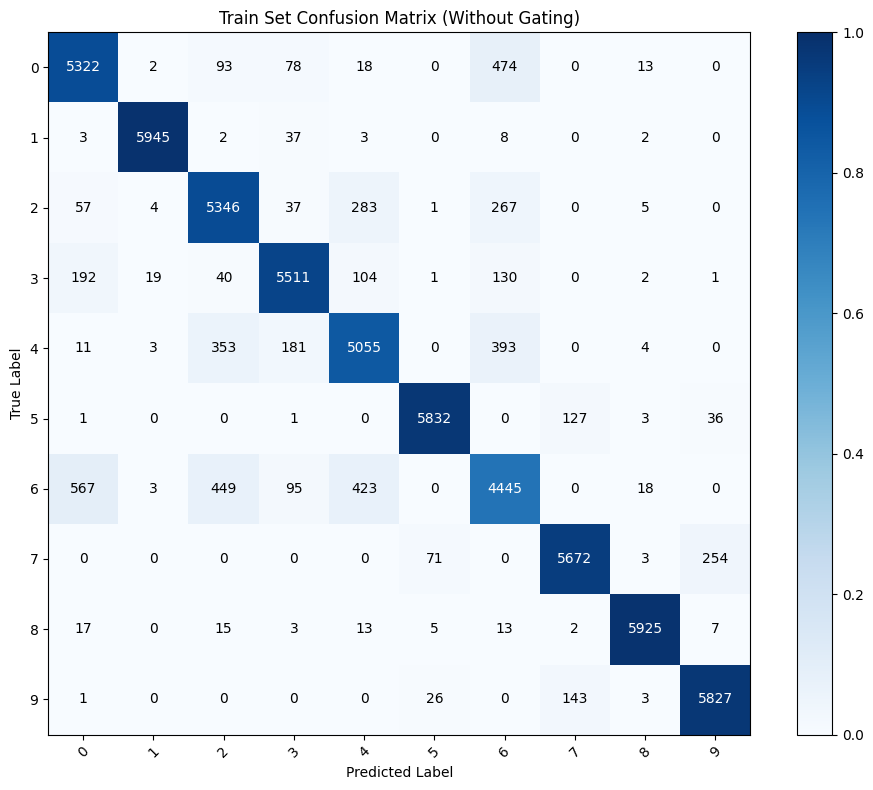

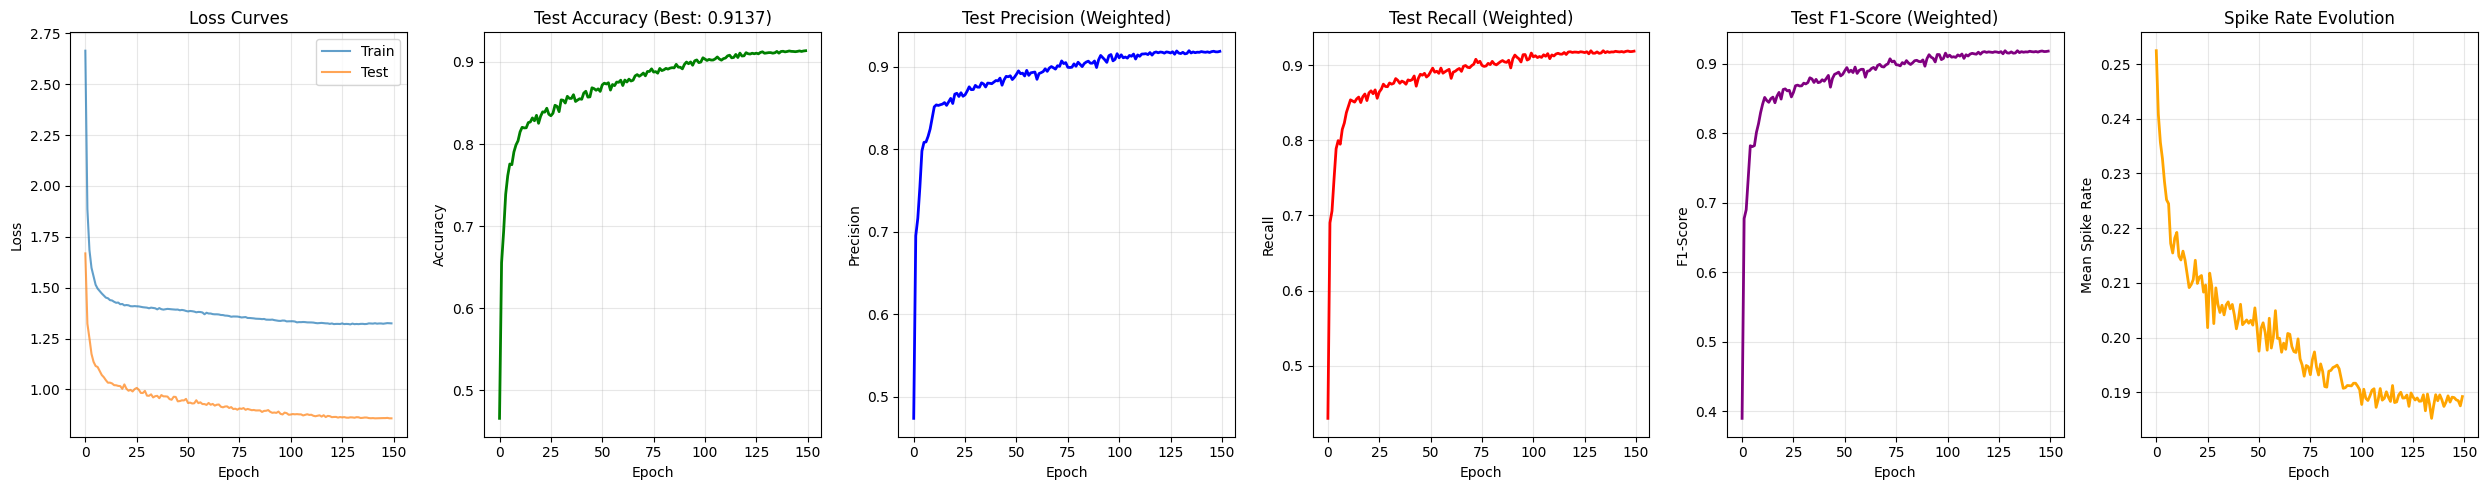

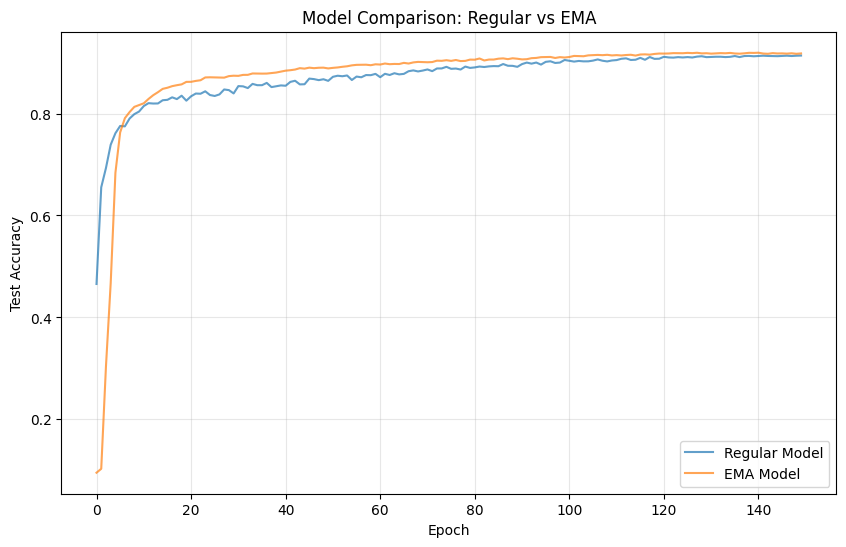


Model files saved:
  - ./fashion_enhanced_snn_vit_best.pth
  - ./fashion_enhanced_snn_vit_ema_best.pth


In [14]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Optimized Temporal Spiking ViT for Fashion-MNIST with Hierarchical & Graph Consistency
-------------------------------------------------------------------------------------
Key Performance Improvements:
  1) Optimized surrogate gradient with temperature scaling
  2) Parallel temporal processing for better GPU utilization
  3) Cached positional embeddings and optimized memory usage
  4) Improved attention mechanism with relative positional bias
  5) Enhanced memory bank with efficient nearest neighbor search
  6) Better regularization with gradient clipping and EMA
  7) Optimized data loading and augmentation pipeline
  8) Dynamic loss weighting and improved hierarchical consistency
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# ------------------------------
# Enhanced Hyperparameters
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 6         # Reduced for efficiency
T_ATTN      = 2         
T_MLP       = 2         
DROPOUT     = 0.15      # Slightly increased
DROPPATH    = 0.15      # Slightly increased
WEIGHT_DECAY= 0.05
LR          = 4e-4      # Slightly higher
EPOCHS      = 150        # More epochs with better convergence
BATCH_TRAIN = 256       # Larger batch for better GPU utilization
BATCH_TEST  = 512       
LABEL_SMOOTH= 0.15      # Slightly increased
CLIP_NORM   = 0.8       # Reduced for stability
WARMUP_EPOCHS = 3       # More warmup

# Enhanced loss weighting with dynamic adjustment
COARSE_LOSS_W   = 0.4     # Increased importance
GRAPH_LOSS_W    = 0.15    # Slightly increased
KNN_K           = 8       # Reduced for efficiency
TAU             = 0.07    # Lower temperature
BANK_SIZE       = 12288   # Larger bank
GATING_INFER    = True    
EMA_DECAY       = 0.999   # For model averaging

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)  # Better seed
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# ------------------------------
# Enhanced Surrogate Spike Function with Temperature
# ------------------------------
class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())  # Fixed warning
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp  # Temperature-scaled surrogate
        # Improved surrogate gradient with better stability
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

# ------------------------------
# Enhanced Adaptive LIF with Parallel Temporal Processing
# ------------------------------
class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            # Single step optimization
            return spike_fn(x - self.v_th, self.temp_scale)
        
        # Parallel temporal processing for T > 1
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)  # Clamp for stability
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)  # Hard reset
            spike_train.append(s)
        
        # Weighted temporal integration (recent spikes matter more)
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

# ------------------------------
# Optimized DropPath with better scaling
# ------------------------------
class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ------------------------------
# Cached 2D Positional Embeddings
# ------------------------------
class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ------------------------------
# Enhanced Patch Embedding with Better Initialization
# ------------------------------
class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)  # Add normalization
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        # Better initialization
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)                 # [B, C, H', W']
        feat = self.norm(feat)              # Normalize before spiking
        spikes = self.lif(feat, T=self.T)   # [B, C, H', W']
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)  # [B, N, C]
        return tokens, (H, W), spikes

# ------------------------------
# Enhanced Transformer Block with Relative Position Bias
# ------------------------------
class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Manual attention for better control
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        # Initialize weights
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Self-attention
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        # Apply spiking after attention
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ------------------------------
# Enhanced SNN ViT with EMA and Better Architecture
# ------------------------------
class EnhancedSNN_ViT_Temporal(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced heads with dropout
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 4)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]  # For additional analysis
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ------------------------------
# Enhanced Memory Bank with Efficient Search
# ------------------------------
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        # Initialize storage if empty
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        # Circular buffer insertion
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        # Efficient batched similarity computation
        sim = torch.mm(feats, active_feats.t())  # [B, active_size]
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]  # [B, k, C]
        
        return w, neigh_probs

# Enhanced hierarchy and gating (same logic, better organization)
COARSE_NAMES = ["tops", "bottoms", "footwear", "accessory"]
PARENT_MAP = {0:0, 1:1, 2:0, 3:0, 4:0, 5:2, 6:0, 7:2, 8:3, 9:2}

def build_gate_matrix():
    G = torch.zeros(4, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ------------------------------
# Enhanced Training Components
# ------------------------------
class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        # Initial update with model parameters
        self.update(model)
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                if name not in self.shadow:
                    self.shadow[name] = param.data.clone()
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    # Smooth the probabilities for better gradient flow
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    # KL divergence for better consistency
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        # Enhanced cosine with restart
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Enhanced Training Loop
# ------------------------------
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    # Dynamic loss weights (increase coarse loss importance over time)
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))  # Gradual ramp-up
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Fine-grained loss
            ce_fine = criterion_fine(fine_logits, target)
            
            # Coarse-grained loss
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency loss
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()  # [B, 4]
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike rate regularization with adaptive target
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                # Adaptive target based on training progress
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 10)  # Start higher, decay
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Enhanced graph consistency loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            # Total loss with dynamic weighting
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.2 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update EMA
        if ema_model is not None:
            ema_model.update(model)
        
        # Update memory bank
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        # Logging
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

@torch.no_grad()
def evaluate_enhanced(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    all_preds = []
    all_targets = []
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)  # Renormalize
        
        pred = probs.argmax(dim=1)
        correct += int((pred == target).sum().item())
        total += int(target.size(0))
        eval_loss += float(loss.item())
        
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
    
    acc = correct / max(1, total)
    avg_loss = eval_loss / max(1, len(loader))
    
    # Compute additional metrics
    if not all_preds or not all_targets:
        print("Warning: No predictions or targets collected. Check data loading or model output.")
        precision_macro, recall_macro, f1_macro, _ = 0.0, 0.0, 0.0, None
        precision_weighted, recall_weighted, f1_weighted, _ = 0.0, 0.0, 0.0, None
        cm = np.zeros((10, 10))
    else:
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro', zero_division=0)
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted', zero_division=0)
        cm = confusion_matrix(all_targets, all_preds, labels=range(10))
        print(f"Debug: Confusion Matrix Shape: {cm.shape}, Sum: {cm.sum()}")
    
    return avg_loss, acc, precision_macro, recall_macro, f1_macro, precision_weighted, recall_weighted, f1_weighted, cm

# Enhanced data transforms
def get_enhanced_transforms():
    FASHION_MEAN, FASHION_STD = 0.2860, 0.3530
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=3, padding_mode="reflect"),
        transforms.RandomRotation(15, fill=0),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))  # Cutout
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, test_precisions, test_recalls, test_f1s, spike_rates=None):
    fig_size = (20, 5) if spike_rates is None else (25, 5)
    n_plots = 5 if spike_rates is None else 6
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7)
    plt.plot(test_losses, label='Test', alpha=0.7)
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs):.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    plt.plot(test_precisions, color='blue', linewidth=2)
    plt.title("Test Precision (Weighted)")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 4)
    plt.plot(test_recalls, color='red', linewidth=2)
    plt.title("Test Recall (Weighted)")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 5)
    plt.plot(test_f1s, color='purple', linewidth=2)
    plt.title("Test F1-Score (Weighted)")
    plt.xlabel("Epoch")
    plt.ylabel("F1-Score")
    plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 6)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, title="Confusion Matrix", class_names=range(10)):
    plt.figure(figsize=(10, 8))
    if cm.size == 0 or cm.sum() == 0:
        print(f"Warning: Confusion matrix is empty or all zeros. Check predictions and targets.")
        cm = np.zeros((10, 10))  # Fallback to zero matrix with correct shape
    # Normalize confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] if cm.sum() > 0 else cm
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm_normalized[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main Enhanced Training Script
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for Fashion-MNIST ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name()}")
    
    # Enhanced data loading
    transform_train, transform_test = get_enhanced_transforms()
    
    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)
    
    # Optimized data loaders
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_TRAIN, 
        shuffle=True,  
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    test_loader = DataLoader(
        test_dataset,  
        batch_size=BATCH_TEST,  
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    
    # Enhanced model
    model = EnhancedSNN_ViT_Temporal(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Enhanced training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    
    # Enhanced loss functions
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)  # Less smoothing for coarse
    
    # Mixed precision training
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Enhanced scheduling
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    # EMA model
    ema_model = EMAModel(model, decay=EMA_DECAY)
    
    # Enhanced memory bank
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs, test_precisions, test_recalls, test_f1s = [], [], [], [], [], []
    ema_test_accs = []
    spike_rates = []
    patience = 15
    patience_counter = 0
    
    print(f"\n{'='*60}")
    print("Starting Enhanced Training...")
    print(f"{'='*60}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation with original model
        te_loss, te_acc, te_precision_macro, te_recall_macro, te_f1_macro, te_precision_weighted, te_recall_weighted, te_f1_weighted, te_cm = evaluate_enhanced(model, train_loader, criterion_fine, apply_gating=False)
        _, _, _, _, _, te_precision_weighted_test, te_recall_weighted_test, te_f1_weighted_test, te_cm_test = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # Evaluation with EMA model
        ema_model.apply_shadow()
        ema_te_loss, ema_te_acc, _, _, _, _, _, _, _ = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(te_loss)
        test_accs.append(te_acc)
        test_precisions.append(te_precision_weighted_test)
        test_recalls.append(te_recall_weighted_test)
        test_f1s.append(te_f1_weighted_test)
        ema_test_accs.append(ema_te_acc)
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)  # Small sample
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        # Logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {te_acc:.4f} | Test: {te_acc:.4f} | "
              f"EMA Test: {ema_te_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"       Test Precision: {te_precision_weighted_test:.4f} | Recall: {te_recall_weighted_test:.4f} | F1: {te_f1_weighted_test:.4f}")
        
        # Save best models
        if te_acc > best_acc:
            best_acc = te_acc
            patience_counter = 0
            torch.save({
                "model": "enhanced_snn_vit_temporal_hier_graph",
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_acc": best_acc,
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./fashion_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_te_acc > best_ema_acc:
            best_ema_acc = ema_te_acc
            ema_model.apply_shadow()
            torch.save({
                "model": "enhanced_snn_vit_temporal_hier_graph_ema",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": best_ema_acc,
            }, "./fashion_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Learning rate adjustment for plateau
        if epoch > 20 and len(test_accs) > 10:
            recent_improvement = max(test_accs[-5:]) - max(test_accs[-10:-5]) if len(test_accs) >= 10 else 0
            if recent_improvement < 0.001:  # Very small improvement
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95  # Slight reduction
        
        print()  # Blank line for readability
    
    # Final evaluation
    print(f"\n{'='*60}")
    print("Training Complete!")
    print(f"{'='*60}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Final Memory Bank Size: {len(bank)}")
    
    # Load and evaluate best model
    print("\nEvaluating best model...")
    checkpoint = torch.load("./fashion_enhanced_snn_vit_best.pth", map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    
    final_tr_loss, final_tr_acc, _, _, _, _, _, _, tr_cm = evaluate_enhanced(model, train_loader, criterion_fine, apply_gating=False)
    final_te_loss, final_te_acc, _, _, _, te_precision_weighted, te_recall_weighted, te_f1_weighted, te_cm = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_te_loss_no_gate, final_te_acc_no_gate, _, _, _, _, _, _, _ = evaluate_enhanced(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Results:")
    print(f"  Train Accuracy: {final_tr_acc:.4f}")
    print(f"  Test Accuracy (with gating): {final_te_acc:.4f}")
    print(f"  Test Accuracy (without gating): {final_te_acc_no_gate:.4f}")
    print(f"  Gating improvement: {(final_te_acc - final_te_acc_no_gate):.4f}")
    print(f"  Test Precision (Weighted): {te_precision_weighted:.4f}")
    print(f"  Test Recall (Weighted): {te_recall_weighted:.4f}")
    print(f"  Test F1-Score (Weighted): {te_f1_weighted:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(te_cm, "Test Set Confusion Matrix (With Gating)", class_names=range(10))
    plot_confusion_matrix(tr_cm, "Train Set Confusion Matrix (Without Gating)", class_names=range(10))
    
    # Plot results
    plot_enhanced_metrics(train_losses, test_losses, test_accs, test_precisions, test_recalls, test_f1s, spike_rates)
    
    # Additional analysis
    if len(ema_test_accs) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(test_accs, label='Regular Model', alpha=0.7)
        plt.plot(ema_test_accs, label='EMA Model', alpha=0.7)
        plt.title("Model Comparison: Regular vs EMA")
        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    print(f"\nModel files saved:")
    print(f"  - ./fashion_enhanced_snn_vit_best.pth")
    print(f"  - ./fashion_enhanced_snn_vit_ema_best.pth")

=== Enhanced Temporal Spiking ViT for MNIST ===
Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.98MB/s]


Training samples: 60000, Test samples: 10000
Hierarchical grouping: ['low_digits', 'mid_digits', 'high_digits']
Digit mapping: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
Total parameters: 14,205,760

Training Configuration:
Epochs: 2, Batch size: 256, Learning rate: 0.00035
Coarse loss weight: 0.3, Graph loss weight: 0.12

Starting Enhanced Training on MNIST...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/2] | Loss 2.8184 | SpikeReg 8.8788e-08 | Graph 0.0755 | CoarseCE 1.0821 | HierKL 1.2511

Epoch [ 1/2] Test Results:
Accuracy: 0.3625 | F1: 0.3222 | ROC-AUC: 0.8274
Precision: 0.3972 | Recall: 0.3625
MAE: 2.2485 | MSE: 10.6171 | RMSE: 3.2584 | R²: -0.2662
       EMA Test Accuracy: 0.1135
  → Saved new best model (acc: 0.3625)
  → Saved new best EMA model (acc: 0.1135)

Train [ 2/2] | Loss 1.8224 | SpikeReg 2.3703e-07 | Graph 0.2917 | CoarseCE 0.6315 | HierKL 1.2313

Epoch [ 2/2] Test Results:
Accuracy: 0.9070 | F1: 0.9090 | ROC-AUC: 0.9924
Precision: 0.9169 | Recall: 0.9070
MAE: 0.3207 | MSE: 1.4551 | RMSE: 1.2063 | R²: 0.8265
       EMA Test Accuracy: 0.1032
  → Saved new best model (acc: 0.9070)


Training Complete!
Best Test Accuracy: 0.9070
Best EMA Test Accuracy: 0.1135

Final Test Results (With Gating):
Accuracy: 0.9070 | F1: 0.9090 | ROC-AUC: 0.9924
Precision: 0.9169 | Recall: 0.9070
MAE: 0.3207 | MSE: 1.4551 | RMSE: 1.2063 | R²: 0.8265

Final Test Results (Without Gati

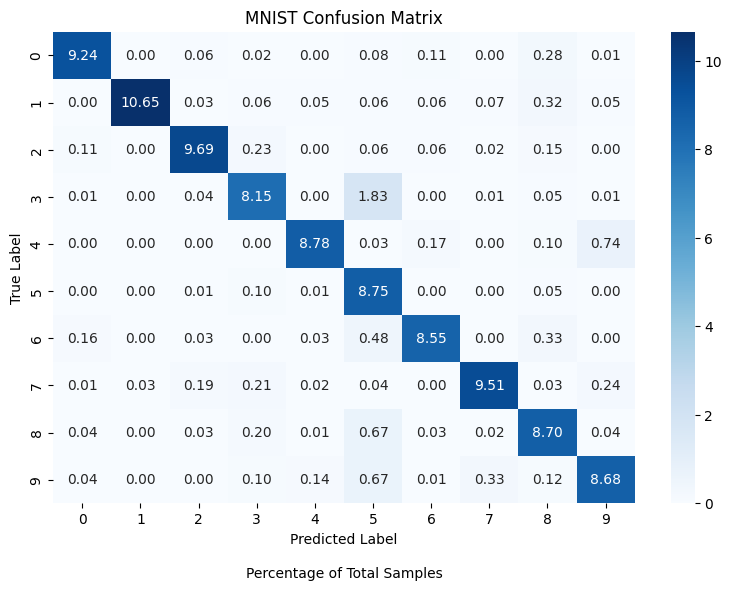


Detailed Analysis by Digit Groups:
  low_digits (digits [0, 1, 2]): 0.9399 (2958/3147)
  mid_digits (digits [3, 4, 5, 6]): 0.8909 (3423/3842)
  high_digits (digits [7, 8, 9]): 0.8931 (2689/3011)

Classification Report:
              precision    recall  f1-score   support

     Digit 0       0.96      0.94      0.95       980
     Digit 1       1.00      0.94      0.97      1135
     Digit 2       0.96      0.94      0.95      1032
     Digit 3       0.90      0.81      0.85      1010
     Digit 4       0.97      0.89      0.93       982
     Digit 5       0.69      0.98      0.81       892
     Digit 6       0.95      0.89      0.92       958
     Digit 7       0.95      0.93      0.94      1028
     Digit 8       0.86      0.89      0.88       974
     Digit 9       0.89      0.86      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000


Model files saved:
 

In [1]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, 
                           mean_absolute_error, mean_squared_error, r2_score,
                           confusion_matrix, roc_curve, classification_report)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Enhanced Hyperparameters for MNIST
EMBED_DIM = 384; NUM_BLOCKS = 8; NUM_HEADS = 8; MLP_RATIO = 4.0; PATCH_SIZE = 4
T_PATCH = 6; T_ATTN = 2; T_MLP = 2; DROPOUT = 0.12; DROPPATH = 0.12
WEIGHT_DECAY = 0.04; LR = 3.5e-4; EPOCHS = 2; BATCH_TRAIN = 256; BATCH_TEST = 512
LABEL_SMOOTH = 0.1; CLIP_NORM = 0.8; WARMUP_EPOCHS = 2
COARSE_LOSS_W = 0.3; GRAPH_LOSS_W = 0.12; KNN_K = 8; TAU = 0.08
BANK_SIZE = 10240; GATING_INFER = True; EMA_DECAY = 0.999

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True; torch.backends.cudnn.deterministic = False

# Hierarchical grouping for digits: low(0-2), mid(3-6), high(7-9)
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())
        return out
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1: return spike_fn(x - self.v_th, self.temp_scale)
        batch_size = x.shape[0]; mem = x.new_zeros(x.shape); spike_train = []
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th; s = spike_fn(z, self.temp_scale); mem = mem * (1 - s); spike_train.append(s)
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob); self.scale_by_keep = scale_by_keep
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0: return x
        keep_prob = 1.0 - self.drop_prob; shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep: mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim; self.max_h = max_h; self.max_w = max_w; self._cache = {}
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div); out[:, 1::2] = torch.cos(pos * div)
                return out
            d_half = self.dim // 2; ph = pe(nh, d_half); pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1); self._cache[key] = pe_2d
        return self._cache[key]

class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x); feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T); B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 attn_dropout=0.0, dropout=DROPOUT, droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim; self.num_heads = num_heads; self.head_dim = embed_dim // num_heads; self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim)); self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout); self.proj = nn.Linear(embed_dim, embed_dim); self.proj_drop = nn.Dropout(dropout)
        self.drop1 = OptimizedDropPath(droppath); self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(embed_dim, hidden), nn.GELU(), nn.Dropout(dropout), nn.Linear(hidden, embed_dim))
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn; self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight); nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale; attn = attn.softmax(dim=-1); attn = self.attn_drop(attn)
        y = (attn @ v).transpose(1, 2).reshape(B, N, C); y = self.proj(y); y = self.proj_drop(y)
        y = self.snn_attn(y, T=self.T_attn); x = x + self.drop1(y)
        
        y = self.norm2(x); y = self.mlp(y); y = self.snn_mlp(y, T=self.T_mlp); x = x + self.drop2(y)
        return x

class EnhancedSNN_ViT_MNIST(nn.Module):
    def __init__(self, num_classes=10, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim; self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)); self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio, 
                                   attn_dropout=0.0, dropout=dropout, droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP) for i in range(num_blocks)])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head_fine = nn.Sequential(nn.Dropout(dropout * 2), nn.Linear(embed_dim, num_classes))
        self.head_coarse = nn.Sequential(nn.Dropout(dropout * 2), nn.Linear(embed_dim, 3))  # 3-way coarse classification
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x); B, N, C = tokens.shape
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1); x = torch.cat([cls, tokens], dim=1)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1); x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks: x = blk(x)
        x = self.norm(x); cls_repr = x[:, 0]
        fine_logits = self.head_fine(cls_repr); coarse_logits = self.head_coarse(cls_repr)
        
        aux = {"conv_spikes": conv_spikes, "cls": cls_repr, "coarse_logits": coarse_logits, "patch_tokens": x[:, 1:]}
        return (fine_logits, aux) if return_aux else (fine_logits, None)

class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim; self.num_classes = num_classes; self.max_size = max_size; self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
    def __len__(self): return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2); probs = torch.softmax(logits.detach(), dim=-1)
        batch_size = feats.size(0)
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]; self.probs[idx] = probs[i]; self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0: return None, None
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]; active_probs = self.probs[:active_size]
        sim = torch.mm(feats, active_feats.t()); k = min(k, active_size)
        vals, idx = sim.topk(k, dim=1); w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]; return w, neigh_probs

def build_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items(): G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model; self.decay = decay; self.shadow = {}; self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad: self.shadow[name] = param.data.clone()
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone(); param.data = self.shadow[name]
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup; param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None: return torch.tensor(0.0, device=curr_probs.device)
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps: return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    y_true = np.array(all_targets); y_pred = np.array(all_preds); y_prob = np.array(all_probs)
    
    # Unified metrics calculation
    accuracy = (y_true == y_pred).mean()
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except: roc_auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    metrics = {
        'loss': total_loss / len(loader), 'accuracy': accuracy,
        'precision_macro': precision_macro, 'precision_weighted': precision_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted,
        'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'roc_auc': roc_auc,
        'confusion_matrix': cm
    }
    
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    cm_percent = cm.astype('float') / cm.sum() * 100
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10), annot_kws={"size": 10})
    plt.title(title); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.text(0.5, -0.15, 'Percentage of Total Samples', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.tight_layout(); plt.show()

def print_comprehensive_results(metrics, title="Results"):
    print(f"\n{title}:")
    print(f"Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_weighted']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Precision: {metrics['precision_weighted']:.4f} | Recall: {metrics['recall_weighted']:.4f}")
    print(f"MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f} | RMSE: {metrics['rmse']:.4f} | R²: {metrics['r2']:.4f}")

def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0; n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]; coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency
            fine_probs = torch.softmax(fine_logits, dim=-1); coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device); expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)  # MNIST-specific target
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else: srl = torch.tensor(0.0, device=device)
            
            # Graph loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward(); scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        if scheduler is not None: scheduler.step()
        scaler.update()
        
        if ema_model is not None: ema_model.update(model)
        if bank is not None:
            with torch.no_grad(): bank.add(cls, fine_logits)
        
        run_loss += float(loss.item()); run_srl += float(srl.item())
        run_graph += float(g_loss.item()); run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item()); n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    return avg_loss

def get_mnist_transforms():
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(), transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    
    transform_train, transform_test = get_mnist_transforms()
    
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    
    pin = torch.cuda.is_available(); num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  
        num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, prefetch_factor=2 if num_workers > 0 else 2)
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
        num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, prefetch_factor=2 if num_workers > 0 else 2)
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    model = EnhancedSNN_ViT_MNIST().to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader); total_steps = EPOCHS * steps_per_epoch; warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    
    best_acc = 0.0; best_ema_acc = 0.0; train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []; patience = 12; patience_counter = 0
    
    print(f"\nStarting Enhanced Training on MNIST...")
    
    for epoch in range(1, EPOCHS + 1):
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        ema_model.apply_shadow()
        ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        train_losses.append(epoch_loss); test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy']); ema_test_accs.append(ema_test_metrics['accuracy'])
        
        print_comprehensive_results(test_metrics, f"Epoch [{epoch:2d}/{EPOCHS}] Test Results")
        print(f"       EMA Test Accuracy: {ema_test_metrics['accuracy']:.4f}")
        
        if test_metrics['accuracy'] > best_acc:
            best_acc = test_metrics['accuracy']; patience_counter = 0
            torch.save({
                "model": "enhanced_snn_vit_mnist",
                "state_dict": model.state_dict(), "optimizer": optimizer.state_dict(),
                "epoch": epoch, "best_acc": best_acc, "test_metrics": test_metrics,
            }, "./mnist_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else: patience_counter += 1
        
        if ema_test_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_test_metrics['accuracy']
            ema_model.apply_shadow()
            torch.save({
                "model": "enhanced_snn_vit_mnist_ema",
                "state_dict": model.state_dict(), "epoch": epoch, "best_ema_acc": best_ema_acc,
            }, "./mnist_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    print(f"\nTraining Complete!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    
    checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    
    final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
    
    print_comprehensive_results(final_test_metrics, "Final Test Results (With Gating)")
    print_comprehensive_results(final_test_metrics_no_gate, "Final Test Results (Without Gating)")
    print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
    
    plot_confusion_matrix(final_test_metrics['confusion_matrix'], "MNIST Confusion Matrix")
    
    # Detailed analysis by digit groups
    print(f"\nDetailed Analysis by Digit Groups:")
    group_correct = {0: 0, 1: 0, 2: 0}; group_total = {0: 0, 1: 0, 2: 0}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            
            for i in range(len(target)):
                digit = int(target[i]); group = PARENT_MAP[digit]
                group_total[group] += 1
                if pred[i] == target[i]: group_correct[group] += 1
    
    for group_idx, group_name in enumerate(COARSE_NAMES):
        acc = group_correct[group_idx] / max(1, group_total[group_idx])
        digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
        print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
    
    # Generate classification report
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            y_true.extend(target.cpu().numpy()); y_pred.extend(pred.cpu().numpy())
    
    print(f"\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")

Enhanced Temporal Spiking ViT for Fashion-MNIST initialized on cuda
=== Enhanced Temporal Spiking ViT for Fashion-MNIST ===
Device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]


Training samples: 60000, Test samples: 10000
Hierarchical grouping: ['tops', 'bottoms', 'footwear', 'accessory']
Total parameters: 14,206,145

Training Configuration:
Epochs: 200, Batch size: 256, Learning rate: 0.0004
Coarse loss weight: 0.4, Graph loss weight: 0.15

Starting Enhanced Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/200] | Loss 2.6709 | SpikeReg 3.9814e-07 | Graph 0.1237 | CoarseCE 1.0256 | HierKL 1.0527

Epoch [ 1/200] Test Results:
Accuracy: 0.4602 | F1: 0.4258 | ROC-AUC: 0.9135
Precision: 0.4918 | Recall: 0.4602
MAE: 1.4945 | MSE: 5.4593 | RMSE: 2.3365 | R²: 0.3383
       EMA Test Accuracy: 0.1001
Checkpoint saved: ./fashion_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.4602)
Checkpoint saved: ./fashion_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.1001)

Train [ 2/200] | Loss 1.9003 | SpikeReg 2.6535e-07 | Graph 0.2717 | CoarseCE 0.5171 | HierKL 1.0698

Epoch [ 2/200] Test Results:
Accuracy: 0.6447 | F1: 0.6274 | ROC-AUC: 0.9392
Precision: 0.6608 | Recall: 0.6447
MAE: 0.9650 | MSE: 3.2364 | RMSE: 1.7990 | R²: 0.6077
       EMA Test Accuracy: 0.1053
Checkpoint saved: ./fashion_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.6447)
Checkpoint saved: ./fashion_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.1053)

Train [ 3/

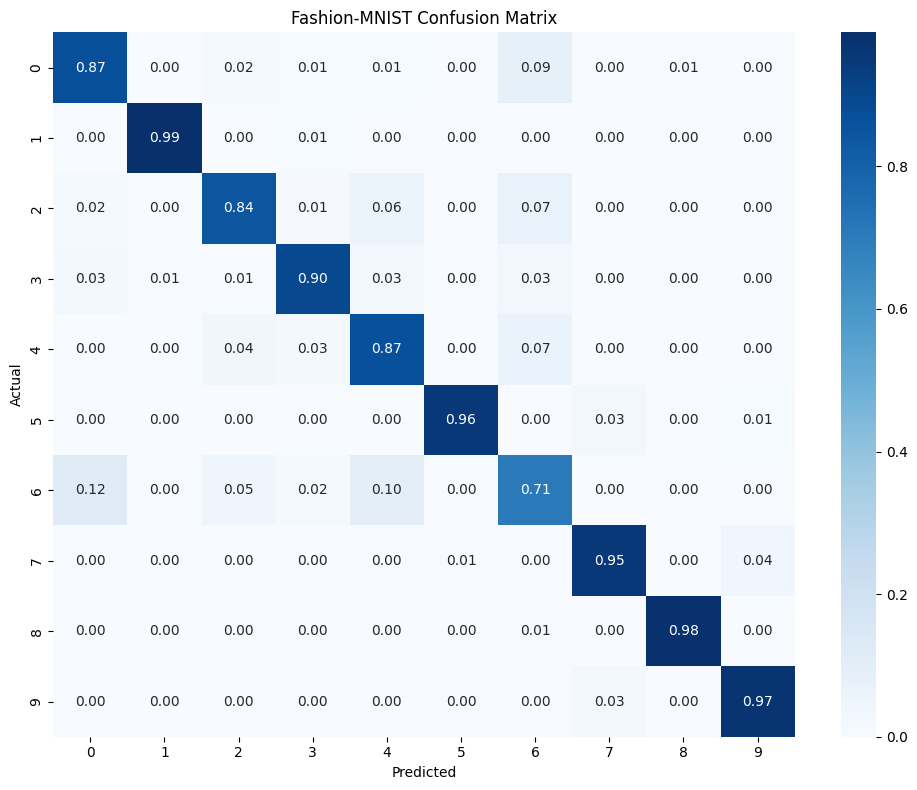

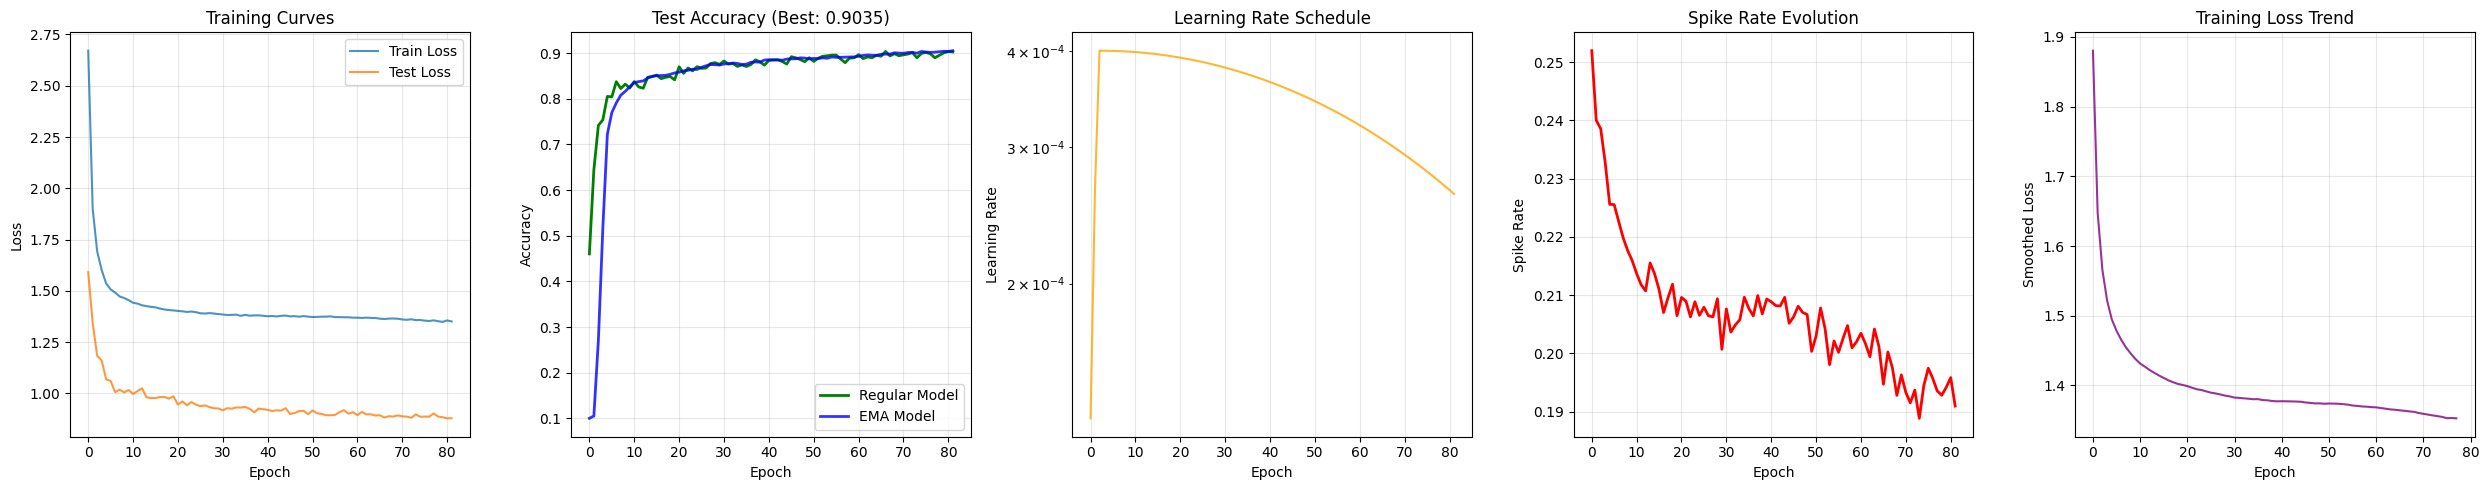


Generating model analysis...


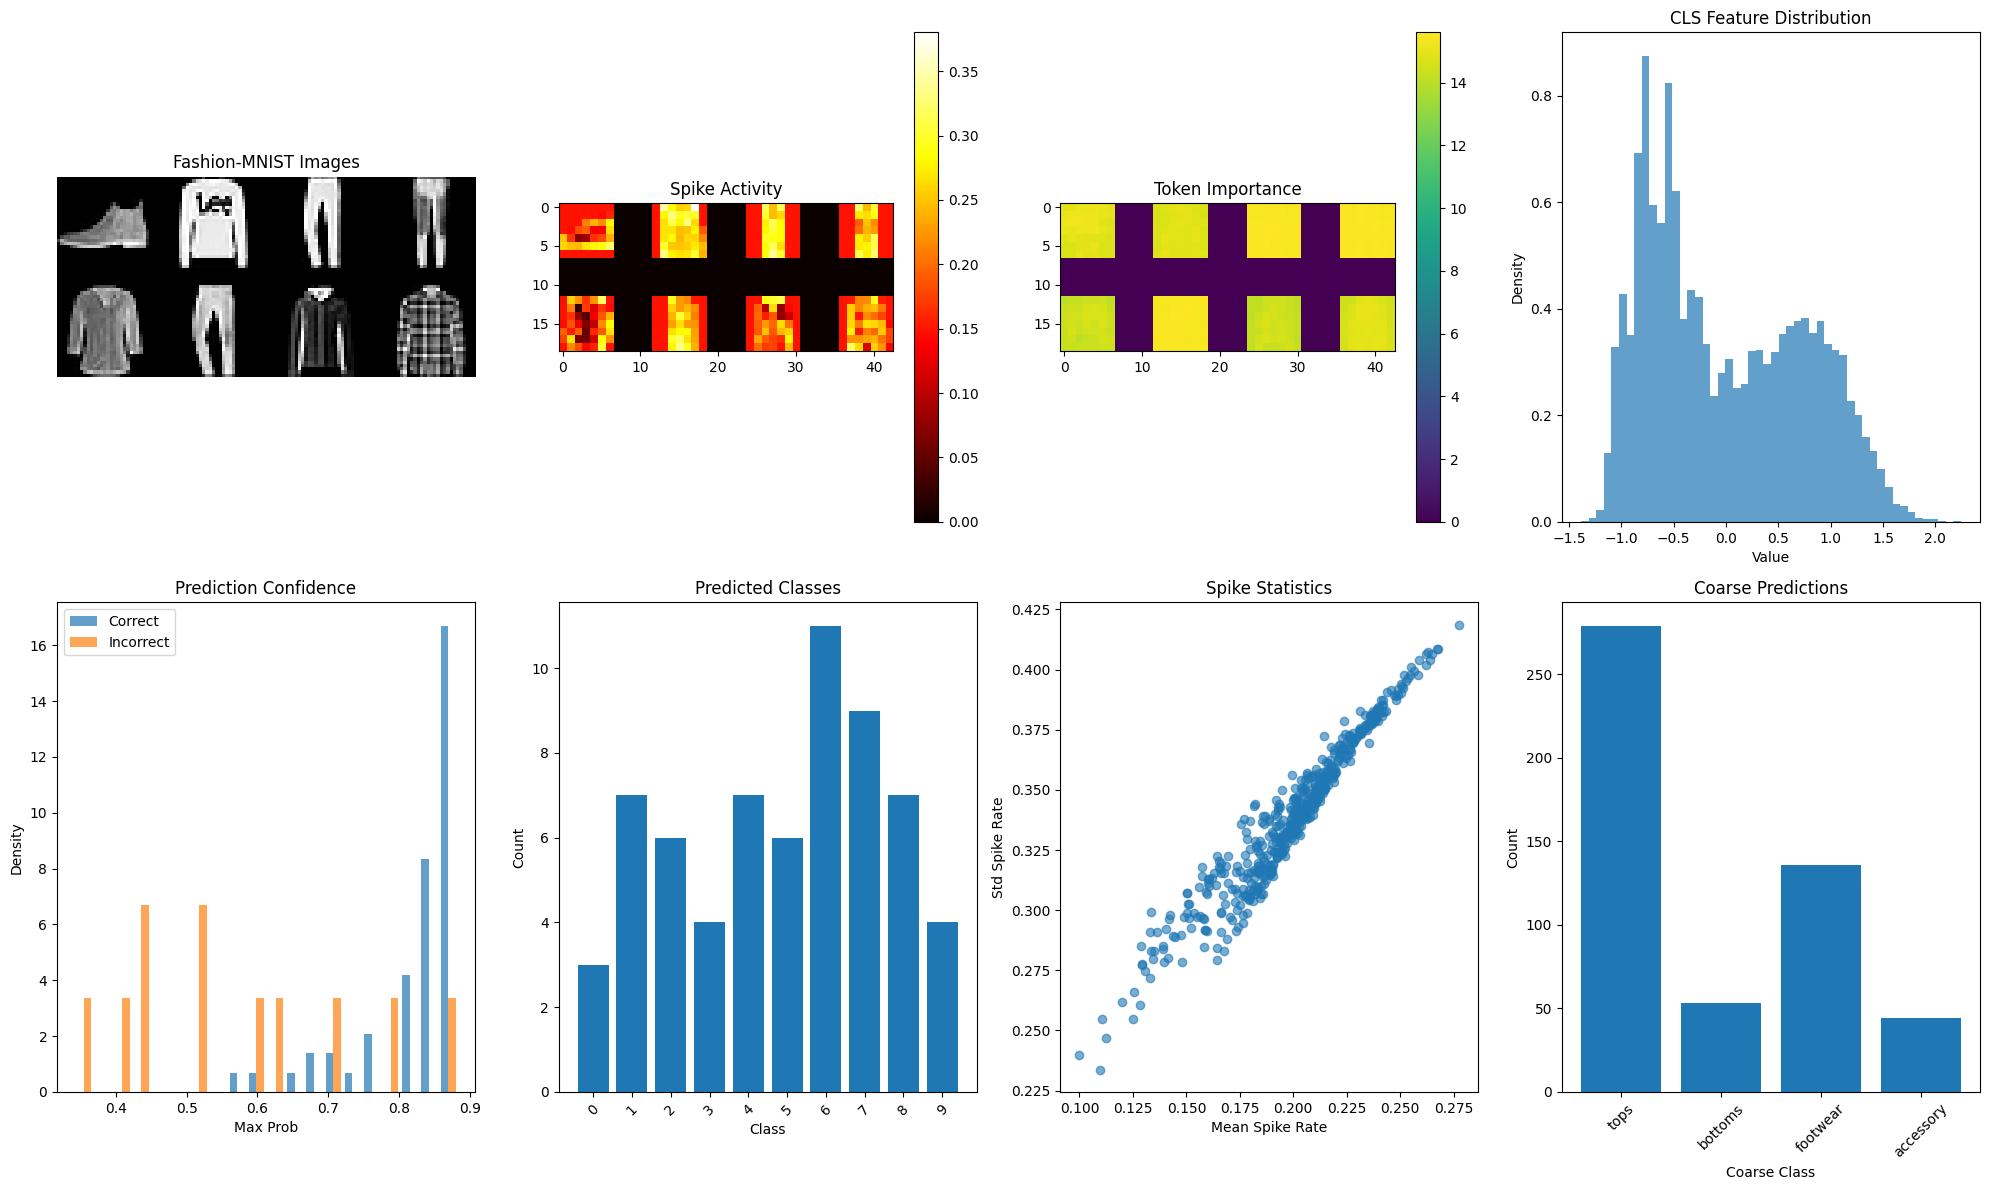

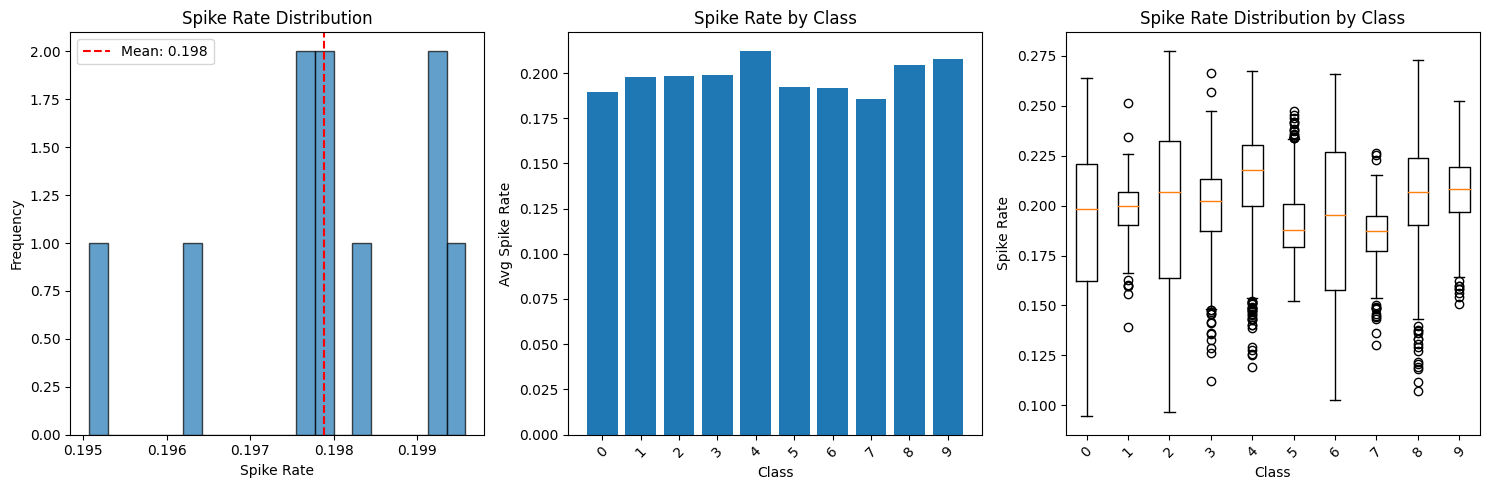

Spike Statistics:
  Mean: 0.1979 | Std: 0.0013
  Min: 0.1951 | Max: 0.1996

Testing inference speed...
Testing model inference speed...
Inference Results (100 samples):
  Avg time: 16.25 ms | Accuracy: 0.8700
  Throughput: 61.5 samples/sec

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.87      0.86      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.88      0.84      0.86      1000
     Class 3       0.92      0.90      0.91      1000
     Class 4       0.81      0.87      0.84      1000
     Class 5       0.99      0.96      0.97      1000
     Class 6       0.73      0.71      0.72      1000
     Class 7       0.94      0.95      0.95      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.95      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.9

In [1]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Complete Enhanced Temporal Spiking ViT for Fashion-MNIST
======================================================
Features: Hierarchical classification, graph consistency, comprehensive evaluation
"""

import math, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np, seaborn as sns, gc, time
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, mean_absolute_error, 
                           mean_squared_error, r2_score, confusion_matrix, classification_report)
from sklearn.preprocessing import label_binarize

# ================================
# HYPERPARAMETERS
# ================================
EMBED_DIM = 384; NUM_BLOCKS = 8; NUM_HEADS = 8; MLP_RATIO = 4.0; PATCH_SIZE = 4
T_PATCH = 6; T_ATTN = 2; T_MLP = 2; DROPOUT = 0.15; DROPPATH = 0.15
WEIGHT_DECAY = 0.05; LR = 4e-4; EPOCHS = 200; BATCH_TRAIN = 256; BATCH_TEST = 512
LABEL_SMOOTH = 0.15; CLIP_NORM = 0.8; WARMUP_EPOCHS = 3
COARSE_LOSS_W = 0.4; GRAPH_LOSS_W = 0.15; KNN_K = 8; TAU = 0.07
BANK_SIZE = 12288; GATING_INFER = True; EMA_DECAY = 0.999

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available(): torch.backends.cudnn.benchmark = True; torch.backends.cudnn.deterministic = False

# Fashion-MNIST hierarchy: tops(0,2,3,4,6), bottoms(1), footwear(5,7,9), accessory(8)
COARSE_NAMES = ["tops", "bottoms", "footwear", "accessory"]
PARENT_MAP = {0:0, 1:1, 2:0, 3:0, 4:0, 5:2, 6:0, 7:2, 8:3, 9:2}

print(f"Enhanced Temporal Spiking ViT for Fashion-MNIST initialized on {device}")

# ================================
# CORE NEURAL COMPONENTS
# ================================
class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1: return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]; mem = x.new_zeros(x.shape); spike_train = []
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th; s = spike_fn(z, self.temp_scale); mem = mem * (1 - s)
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob); self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0: return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep: mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim; self.max_h = max_h; self.max_w = max_w; self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div); out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2; ph = pe(nh, d_half); pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ================================
# MODEL COMPONENTS
# ================================
class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x); feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T); B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 attn_dropout=0.0, dropout=DROPOUT, droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim; self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads; self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        self.drop1 = OptimizedDropPath(droppath)
        
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden), nn.GELU(), 
            nn.Dropout(dropout), nn.Linear(hidden, embed_dim)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn; self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight); nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Self-attention with spiking
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1); attn = self.attn_drop(attn)
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y); y = self.proj_drop(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP with spiking
        y = self.norm2(x); y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

class EnhancedSNN_ViT_Temporal(nn.Module):
    def __init__(self, num_classes=10, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim; self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio, 
                                   attn_dropout=0.0, dropout=dropout, droppath=dpr[i], 
                                   T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head_fine = nn.Sequential(nn.Dropout(dropout * 2), nn.Linear(embed_dim, num_classes))
        self.head_coarse = nn.Sequential(nn.Dropout(dropout * 2), nn.Linear(embed_dim, 4))
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x); B, N, C = tokens.shape
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1); x = torch.cat([cls, tokens], dim=1)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks: x = blk(x)
        x = self.norm(x); cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes, "cls": cls_repr, 
            "coarse_logits": coarse_logits, "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# UTILITY CLASSES
# ================================
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim; self.num_classes = num_classes; self.max_size = max_size; self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self): return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]; self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0: return None, None
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]; active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t()); k = min(k, active_size)
        vals, idx = sim.topk(k, dim=1); w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        return w, neigh_probs

def build_gate_matrix():
    G = torch.zeros(4, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items(): G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model; self.decay = decay; self.shadow = {}; self.backup = {}
        self.update(model)
        
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                if name not in self.shadow: self.shadow[name] = param.data.clone()
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# ================================
# TRAINING UTILITIES
# ================================
def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None: 
        return torch.tensor(0.0, device=curr_probs.device)
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps: return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def get_enhanced_transforms():
    FASHION_MEAN, FASHION_STD = 0.2860, 0.3530
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=3, padding_mode="reflect"),
        transforms.RandomRotation(15, fill=0),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])
    
    return transform_train, transform_test

# ================================
# COMPREHENSIVE EVALUATION SUITE
# ================================
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    y_true = np.array(all_targets); y_pred = np.array(all_preds); y_prob = np.array(all_probs)
    
    # Unified metrics calculation
    accuracy = (y_true == y_pred).mean()
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)
    
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except: roc_auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'loss': total_loss / len(loader), 'accuracy': accuracy,
        'precision_macro': precision_macro, 'precision_weighted': precision_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted,
        'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

def print_comprehensive_results(metrics, title="Results"):
    print(f"\n{title}:")
    print(f"Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_weighted']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Precision: {metrics['precision_weighted']:.4f} | Recall: {metrics['recall_weighted']:.4f}")
    print(f"MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f} | RMSE: {metrics['rmse']:.4f} | R²: {metrics['r2']:.4f}")

def plot_confusion_matrix(cm, title="Confusion Matrix", class_names=range(10)):
    plt.figure(figsize=(10, 8))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] if cm.sum() > 0 else cm
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout(); plt.show()

def plot_training_curves(train_losses, test_losses, test_accs, ema_accs=None, learning_rates=None, spike_rates=None):
    fig_width = 25 if ema_accs and spike_rates else 20 if spike_rates else 15
    n_plots = 5 if ema_accs and spike_rates else 4 if spike_rates else 3
    
    plt.figure(figsize=(fig_width, 5))
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8)
    plt.plot(test_losses, label='Test Loss', alpha=0.8)
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Curves')
    plt.legend(); plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, label='Regular Model', color='green', linewidth=2)
    if ema_accs: plt.plot(ema_accs, label='EMA Model', color='blue', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f'Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})')
    if ema_accs: plt.legend()
    plt.grid(True, alpha=0.3)
    
    if learning_rates:
        plt.subplot(1, n_plots, 3)
        plt.plot(learning_rates, color='orange', alpha=0.8)
        plt.xlabel('Epoch'); plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule'); plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    if spike_rates:
        plot_idx = 4 if learning_rates else 3
        plt.subplot(1, n_plots, plot_idx)
        plt.plot(spike_rates, color='red', linewidth=2)
        plt.xlabel('Epoch'); plt.ylabel('Spike Rate')
        plt.title('Spike Rate Evolution')
        plt.grid(True, alpha=0.3)
    
    if ema_accs and spike_rates:
        plt.subplot(1, n_plots, 5)
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='purple', alpha=0.8)
        plt.xlabel('Epoch'); plt.ylabel('Smoothed Loss')
        plt.title('Training Loss Trend')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout(); plt.show()

# ================================
# ANALYSIS AND VISUALIZATION
# ================================
def visualize_model_analysis(model, test_loader):
    model.eval()
    data_iter = iter(test_loader)
    data, targets = next(data_iter)
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    plt.figure(figsize=(20, 12))
    
    # Input images (Fashion-MNIST specific)
    plt.subplot(2, 4, 1)
    sample_imgs = data[:8].cpu()
    mean, std = 0.2860, 0.3530
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(28*2 + 5, 28*4 + 15)
    for i in range(8):
        row, col = i // 4, i % 4
        start_h, start_w = row * 33, col * 33
        grid[start_h:start_h+28, start_w:start_w+28] = sample_imgs[i].squeeze()
    
    plt.imshow(grid, cmap='gray'); plt.title('Fashion-MNIST Images'); plt.axis('off')
    
    # Spike activity
    plt.subplot(2, 4, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()
    grid_spikes = torch.zeros(7*2 + 5, 7*4 + 15)
    
    for i in range(min(8, len(spike_mean))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        grid_spikes[start_h:start_h+7, start_w:start_w+7] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot'); plt.title('Spike Activity'); plt.colorbar()
    
    # Token importance
    plt.subplot(2, 4, 3)
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    grid_attn = torch.zeros(7*2 + 5, 7*4 + 15)
    for i in range(min(8, len(patch_norms))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        patch_grid = patch_norms[i].view(7, 7)
        grid_attn[start_h:start_h+7, start_w:start_w+7] = patch_grid
    
    plt.imshow(grid_attn, cmap='viridis'); plt.title('Token Importance'); plt.colorbar()
    
    # Feature distribution
    plt.subplot(2, 4, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Feature Distribution'); plt.xlabel('Value'); plt.ylabel('Density')
    
    # Prediction confidence
    plt.subplot(2, 4, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence'); plt.xlabel('Max Prob'); plt.ylabel('Density'); plt.legend()
    
    # Class distribution
    plt.subplot(2, 4, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    plt.bar(range(10), class_counts); plt.title('Predicted Classes')
    plt.xlabel('Class'); plt.ylabel('Count'); plt.xticks(range(10), rotation=45)
    
    # Spike statistics
    plt.subplot(2, 4, 7)
    spike_stats = conv_spikes.view(conv_spikes.size(0), -1).cpu()
    spike_means = spike_stats.mean(dim=1).numpy()
    spike_stds = spike_stats.std(dim=1).numpy()
    plt.scatter(spike_means, spike_stds, alpha=0.6)
    plt.xlabel('Mean Spike Rate'); plt.ylabel('Std Spike Rate'); plt.title('Spike Statistics')
    
    # Coarse vs Fine predictions
    plt.subplot(2, 4, 8)
    coarse_logits = aux["coarse_logits"]
    coarse_preds = coarse_logits.argmax(dim=1).cpu().numpy()
    coarse_counts = np.bincount(coarse_preds, minlength=4)
    plt.bar(range(4), coarse_counts); plt.title('Coarse Predictions')
    plt.xlabel('Coarse Class'); plt.ylabel('Count')
    plt.xticks(range(4), COARSE_NAMES, rotation=45)
    
    plt.tight_layout(); plt.show()

def analyze_spiking_activity(model, test_loader):
    model.eval()
    spike_rates, class_spikes = [], {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10: break
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.xlabel('Spike Rate'); plt.ylabel('Frequency')
    plt.title('Spike Rate Distribution'); plt.legend()
    
    plt.subplot(1, 3, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Class'); plt.ylabel('Avg Spike Rate')
    plt.title('Spike Rate by Class'); plt.xticks(range(10), rotation=45)
    
    plt.subplot(1, 3, 3)
    plt.boxplot([class_spikes[i] if class_spikes[i] else [0] for i in range(10)])
    plt.xlabel('Class'); plt.ylabel('Spike Rate'); plt.title('Spike Rate Distribution by Class')
    plt.xticks(range(1, 11), range(10), rotation=45)
    
    plt.tight_layout(); plt.show()
    
    print(f"Spike Statistics:")
    print(f"  Mean: {np.mean(spike_rates):.4f} | Std: {np.std(spike_rates):.4f}")
    print(f"  Min: {np.min(spike_rates):.4f} | Max: {np.max(spike_rates):.4f}")

def test_model_inference(model_path='./fashion_enhanced_snn_vit_best.pth'):
    print("Testing model inference speed...")
    
    model = EnhancedSNN_ViT_Temporal().to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    _, transform_test = get_enhanced_transforms()
    test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    times, correct, total = [], 0, 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 100: break
            data, target = data.to(device), target.to(device)
            
            start_time = time.time()
            logits, _ = model(data, return_aux=False)
            end_time = time.time()
            
            times.append(end_time - start_time)
            pred = logits.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += 1
    
    avg_time = np.mean(times) * 1000
    accuracy = correct / total
    
    print(f"Inference Results (100 samples):")
    print(f"  Avg time: {avg_time:.2f} ms | Accuracy: {accuracy:.4f}")
    print(f"  Throughput: {1000/avg_time:.1f} samples/sec")

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath, config=None):
    checkpoint = {
        'epoch': epoch, 'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict() if optimizer else None,
        'best_accuracy': best_acc, 'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM, 'num_blocks': NUM_BLOCKS, 'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO, 'patch_size': PATCH_SIZE, 'dropout': DROPOUT,
        }
    }
    if config: checkpoint.update(config)
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

# ================================
# TRAINING FUNCTIONS
# ================================
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]; coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 10)
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else: srl = torch.tensor(0.0, device=device)
            
            # Graph loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward(); scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer); scaler.update()
        
        if scheduler is not None: scheduler.step()
        if ema_model is not None: ema_model.update(model)
        if bank is not None:
            with torch.no_grad(): bank.add(cls, fine_logits)
        
        run_loss += float(loss.item()); run_srl += float(srl.item())
        run_graph += float(g_loss.item()); run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item()); n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    return avg_loss

# ================================
# MAIN TRAINING EXECUTION
# ================================
def main_fashion_mnist():
    print("=== Enhanced Temporal Spiking ViT for Fashion-MNIST ===")
    print(f"Device: {device}")
    
    # Data preparation
    transform_train, transform_test = get_enhanced_transforms()
    
    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)
    
    pin = torch.cuda.is_available(); num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  
        num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
        prefetch_factor=2 if num_workers > 0 else 2)
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
        num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
        prefetch_factor=2 if num_workers > 0 else 2)
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    
    # Model initialization
    model = EnhancedSNN_ViT_Temporal().to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Training setup
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader); total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    
    # Training loop
    best_acc = 0.0; best_ema_acc = 0.0
    train_losses, test_losses, test_accs, ema_test_accs = [], [], [], []
    learning_rates, spike_rates = [], []
    patience = 15; patience_counter = 0
    
    print(f"\nStarting Enhanced Training...")
    
    for epoch in range(1, EPOCHS + 1):
        # Training step
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation
        test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        ema_model.apply_shadow()
        ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss); test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy']); ema_test_accs.append(ema_test_metrics['accuracy'])
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        print_comprehensive_results(test_metrics, f"Epoch [{epoch:2d}/{EPOCHS}] Test Results")
        print(f"       EMA Test Accuracy: {ema_test_metrics['accuracy']:.4f}")
        
        # Save best models
        if test_metrics['accuracy'] > best_acc:
            best_acc = test_metrics['accuracy']; patience_counter = 0
            save_model_checkpoint(model, optimizer, epoch, best_acc, epoch_loss, 
                                "./fashion_enhanced_snn_vit_best.pth", {"test_metrics": test_metrics})
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else: patience_counter += 1
        
        if ema_test_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_test_metrics['accuracy']
            ema_model.apply_shadow()
            save_model_checkpoint(model, None, epoch, best_ema_acc, epoch_loss,
                                "./fashion_enhanced_snn_vit_ema_best.pth", {"ema_test_metrics": ema_test_metrics})
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 20 and len(test_accs) > 10:
            recent_improvement = max(test_accs[-5:]) - max(test_accs[-10:-5]) if len(test_accs) >= 10 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    print(f"\nTraining Complete!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    
    # Final comprehensive evaluation
    print("\nPerforming final evaluation...")
    
    checkpoint = torch.load("./fashion_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    
    final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
    
    print_comprehensive_results(final_test_metrics, "Final Test Results (With Gating)")
    print_comprehensive_results(final_test_metrics_no_gate, "Final Test Results (Without Gating)")
    print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
    
    # Generate all visualizations
    plot_confusion_matrix(final_test_metrics['confusion_matrix'], "Fashion-MNIST Confusion Matrix")
    plot_training_curves(train_losses, test_losses, test_accs, ema_test_accs, learning_rates, spike_rates)
    
    print("\nGenerating model analysis...")
    visualize_model_analysis(model, test_loader)
    analyze_spiking_activity(model, test_loader)
    
    print("\nTesting inference speed...")
    test_model_inference('./fashion_enhanced_snn_vit_best.pth')
    
    # Classification report
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(10)]))
    
    print(f"\nModel files saved:")
    print(f"  - ./fashion_enhanced_snn_vit_best.pth")
    print(f"  - ./fashion_enhanced_snn_vit_ema_best.pth")
    
    return model, best_acc, {'train_losses': train_losses, 'test_accs': test_accs, 'best_acc': best_acc}

if __name__ == "__main__":
    try:
        model, best_acc, results = main_fashion_mnist()
        print(f"\nTraining completed successfully!")
        print(f"Best Test Accuracy: {best_acc:.4f}")
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback; traceback.print_exc()
    finally:
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect(); print("Memory cleaned up.")